# Faulty Car Prediction Model - "Avoid getting Kicked"
# Part 3: Classification


From the initial import during our first review in Part 1 , we identified some immediate problems were addressed through the data validation process. Primary issues were related to missing values, as well as adjusting data types to account for the appropriate features. Full field descriptions are provided in **Table 1.2.1 of Part 1: Visualization and Data Preprocessing**.

To address data fields with missing values, we utilized means and modes to impute replacement values for missing values on continuous and ordinal variables, where possible. For categorical variables, we reclassify missing values to an UNKNOWN category for the variable. Finally, the variables PRIMEUNIT and AUCGUART were both found to contain very few real values (as aformentioned above). As a result, it was determined that the best course of action was to remove these data from consideration entirely. As a result these columns were dropped from the data. For more detailed information, please refer to Part 1: Visualization and Data Preprocessing, section **1.3.2: “Data Cleanup and Imputation”**.

Given the data dictionary and definitions are sparse of specific details on units, we chose the conservative route by standardizing all continous variables. In this way, we better guarantee proper representation and weighting of the variables. This procedure is shown in Part 1: Visualization and Data Preprocessing, section **1.3.3 Standardization - Rescaling All Continuous Variables** and is done prior to reviewing Univariant and Bivariate Analysis EDA.

Some variables proved to be highly correlated. To address multicollinearity concerns, all MMR variables were dropped from the final scaled dataset, with the exception of MMRAcquisitionRetailAveragePrice and MMRAcquisitionAuctionAveragePrice. Final profiling for the clean and standarized dataframe, with imputed values, is provided in Part 1: Visualization and Data Preprocessing, section **1.3.5 Standardized and Clean Data Profiling**.

### 2.1.1 Categorization (Target = IsBadBuy)
Much of our data preparation for classification took place in previous labs, so in that regard we refer the reader to that former work. To generally outline this process, we performed necessary imputations and recategorizations for the data to create a complete and tidy dataset. This included the creation of several features such as Mileage categories, Luxury categories, as well as Axel and Cylinder categories. 

After importing the data set, we took two approaches to preparing the data. This was largely due to our experimentation with different packages to perform the analysis. For models leveraging SKLEARN as a model package, transformed the data set into a “one-hot” form for all categories, and the original category fields were dropped. In the case where we leveraged H2O as a model package, we did not perform “one-hot” transformations to the data since H2O performs these functions automatically. 


We scaled our dataset for continuous variables. This was performed after performing our train/test split. We chose a stratified shuffle split given the overall imbalance to the dataset, which was roughly 1/5 in terms of positive to negative IsBadBuy markers for the labels.

In [1]:
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

In [2]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path
    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
        
      

In [3]:
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [4]:
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [5]:
sys.meta_path.append(NotebookFinder())

In [6]:
#Review of overall data quality
def nullcounts(ser):
    return ser.isnull().sum()

def detail_describe(frame, func=['count', nullcounts, 'mean', 'std', 'min', 'median', 'max'],
                    numeric_only=False, **kwargs):
    return frame.agg(func, **kwargs)

## Import Data Prep 

In [7]:
import lab1_final_data_v2_unscaled

importing Jupyter notebook from lab1_final_data_v2_unscaled.ipynb


## Verify Data

In [8]:
kick_data = lab1_final_data_v2_unscaled.kick_imputed

#should be categorical - Add Luxury, Axle, and Mileage
#we drop some of these later, but its good to be comprehensive for the raw data
categorical_features = ['Auction', 'Make', 'Model', 'Trim', 'SubModel',
                        'Color', 'Transmission', 'WheelType', 'Nationality', 
                        'Size', 'TopThreeAmericanName', 'BYRNO',
                        'VNST', 'Luxury', 'Axle', 'Mileage', 'Cylinder']

#should be floats
continuous_features = ['VehOdo', 'MMRAcquisitionAuctionAveragePrice',
                      'MMRAcquisitionRetailAveragePrice',
                      'VehBCost',
                      'WarrantyCost']

#should be int
ordinal_features = ['IsBadBuy', 'PurchDate', 'VehYear',
                    'VehicleAge', 'WheelTypeID',
                    'VNZIP1', 'IsOnlineSale']

kick_data[categorical_features] = kick_data[categorical_features].astype("category")

In [9]:
kick_data

,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionRetailAveragePrice,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost,Mileage,Luxury,Axle,Cylinder
0,0,1260144000,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,RED,AUTO,1,Alloy,89046.0,OTHER ASIAN,MEDIUM,OTHER,8155.0,11636.0,21973,33619,FL,7100.0,0,1113.0,HIGH,0,Unknown,Unknown
1,0,1260144000,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,1,Alloy,93593.0,AMERICAN,LARGE TRUCK,CHRYSLER,6854.0,10897.0,19638,33619,FL,7600.0,0,1053.0,HIGH,0,Unknown,Unknown
2,0,1260144000,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,AUTO,2,Covers,73807.0,AMERICAN,MEDIUM,CHRYSLER,3202.0,6943.0,19638,33619,FL,4900.0,0,1389.0,HIGH,0,Unknown,Unknown
3,0,1260144000,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,SILVER,AUTO,1,Alloy,65617.0,AMERICAN,COMPACT,CHRYSLER,1893.0,4658.0,19638,33619,FL,4100.0,0,630.0,GOOD,0,Unknown,Unknown
4,0,1260144000,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,SILVER,MANUAL,2,Covers,69367.0,AMERICAN,COMPACT,FORD,3913.0,7723.0,19638,33619,FL,4000.0,0,1020.0,HIGH,0,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72978,1,1259712000,ADESA,2001,8,MERCURY,SABLE,GS,4D SEDAN GS,BLACK,AUTO,1,Alloy,45234.0,AMERICAN,MEDIUM,FORD,1996.0,2656.0,18111,30212,GA,4200.0,0,993.0,LOW,0,Unknown,Unknown
72979,0,1259712000,ADESA,2007,2,CHEVROLET,MALIBU 4C,LS,4D SEDAN LS,SILVER,AUTO,1,UNKNOWN,71759.0,AMERICAN,MEDIUM,GM,6418.0,7431.0,18881,30212,GA,6200.0,0,1038.0,HIGH,0,Unknown,Unknown
72980,0,1259712000,ADESA,2005,4,JEEP,GRAND CHEROKEE 2WD V,Lar,4D WAGON LAREDO,SILVER,AUTO,1,Alloy,88500.0,AMERICAN,MEDIUM SUV,CHRYSLER,8545.0,9729.0,18111,30212,GA,8200.0,0,1893.0,HIGH,0,Unknown,Unknown
72981,0,1259712000,ADESA,2006,3,CHEVROLET,IMPALA,LS,4D SEDAN LS,WHITE,AUTO,1,Alloy,79554.0,AMERICAN,LARGE,GM,6420.0,7434.0,18881,30212,GA,7000.0,0,1974.0,HIGH,0,Unknown,Unknown


In [10]:
detail_describe(kick_data)

,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionRetailAveragePrice,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost,Mileage,Luxury,Axle,Cylinder
count,72983.000000,7.298300e+04,72983.0,72983.000000,72983.000000,72983.0,72983.0,72983.0,72983.0,72983.0,72983.0,72983.000000,72983.0,72983.000000,72983.0,72983.0,72983.0,72983.000000,72983.000000,72983.0,72983.000000,72983.0,72983.000000,72983.000000,72983.000000,72983.0,72983.0,72983.0,72983.0
nullcounts,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
mean,0.122988,1.263092e+09,NaN,2005.343052,4.176644,NaN,NaN,NaN,NaN,NaN,NaN,1.472836,NaN,71499.995917,NaN,NaN,NaN,6128.909217,8497.034332,NaN,58043.059945,NaN,6729.249949,0.025280,1276.580985,NaN,NaN,NaN,NaN
std,0.328425,1.819602e+07,NaN,1.731252,1.712210,NaN,NaN,NaN,NaN,NaN,NaN,0.519704,NaN,14578.913128,NaN,NaN,NaN,2461.689142,3155.896033,NaN,26151.640415,NaN,1764.140211,0.156975,598.846788,NaN,NaN,NaN,NaN
min,0.000000,1.231114e+09,NaN,2001.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,4825.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,2764.000000,NaN,1.000000,0.000000,462.000000,NaN,NaN,NaN,NaN
median,0.000000,1.264032e+09,NaN,2005.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,73361.000000,NaN,NaN,NaN,6098.000000,8446.000000,NaN,73108.000000,NaN,6705.000000,0.000000,1155.000000,NaN,NaN,NaN,NaN
max,1.000000,1.293667e+09,NaN,2010.000000,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,115717.000000,NaN,NaN,NaN,35722.000000,39080.000000,NaN,99224.000000,NaN,45469.000000,1.000000,7498.000000,NaN,NaN,NaN,NaN


### 2.1.2 Regression (Target = MMRAcquisitionAuctionAveragePrice)

We reviewed all of the distributions and qq-plots for all of the continuous variables. 
We did not find that any of the continuous variables required transformation. 
All variables that had been removed in the prior labs were not reinstated.


### 2.2.1 For Classification & Regression Tasks
The following fields were dropped from the analysis since they were not needed or duplicative.

1. "PurchDate" represents the transaction date.  Given that most purchases took place at designated auctions-the purchase date was repetative for most entries.  After careful consideration, it was determined that the date did not provide any value and therefore was deleted for simplification purposes.
2. “VehYear” captures the same information as “VehicleAge” and therefore was eliminated from the model due to redundancy. When considering which variable to remove, it was determined that “vehicleAge” provided for greater flexibility by removing the time period constraint.
3. “WheelTypeId” captures the same information as “WheelType” but in variable form and therefore was also removed due to redundancy.
4. “VNZIP1” (zip code) and “VNST” (state abbrev.) both describe the location of the car auction. To help minimize the level of noise and avoid redundancy, “VNZIP1” (zip code) was removed from the model.
5. To stay competitive, car makers introduce new models to market every four to seven years and these models are refreshed with minor functional and cosmetic changes around halfway through their life cycle. As a result, we identified more than 1064 unique model names in our dataset. In response to the noise identified, “Model”, “Trim” and “SubModel” were removed from the model to help reduce the risk of overfitting the model to the data.
6.	“TopThreeAmericanName” and “Nationality” were removed after initial model results indicated that both variables were not significant, nor received any coefficient weights


### 2.2.2  Data Dictionary


|Field Name	|Definition|
|-----------|---------------------|
|IsBadBuy|Identifies if the kicked vehicle was an avoidable purchase |
|Auction|Auction provider at which the  vehicle was purchased|
|VehicleAge|The Years elapsed since the manufacturer's year|
|Make|Vehicle Manufacturer |
|Model|Vehicle Model|
|Color|Vehicle Color|
|Transmission|Vehicles transmission type (Automatic, Manual)|
|WheelType|The vehicle wheel type description (Alloy, Covers, Special)|
|VehOdo|The vehicles odometer reading|
|Size|The size category of the vehicle (Compact, SUV, etc.)|
|MMRAcquisitionAuctionAveragePrice|Acquisition price for this vehicle in average condition at time of purchase|
|MMRAcquisitionRetailAveragePrice|Acquisition price for this vehicle in the retail market in average condition at time of purchase|
|BYRNO|Unique number assigned to the buyer that purchased the vehicle|
|VNST|State where the the car was purchased|
|VehBCost|Acquisition cost paid for the vehicle at time of purchase|
|IsOnlineSale|Identifies if the vehicle was originally purchased online|
|WarrantyCost|Warranty price (term=36month  and millage=36K)|
|Mileage*|Mileage categorization (LOW, GOOD, HIGH)|
|Luxury*|Luxury car identifier|
|Axel*|2WD OR 4WD|
|Cylinder*|Thme number of engine cylinders for the car engine| 
|*|Indicates feature engineering|

## 3.0 Modeling and Evaluation  

### 3.1 Selecting Appropriate Measures for Evaluating Performance Results 

### 3.1.1 Performance Metrics for Classification Tasks
For evaluating the classification of IsBadBuy for our imbalanced dataset, we explored several options including the likes of ROC-AUC, F1, F2, and its varients. Given the small positive class for this binomial classification, the ability to correctly detect positive samples remains the priority. And, there should be reasonable assurance that a car classified as a bad buy, is in fact a bad buy. Correctly identifying negative samples is of lesser concern, compartively. 

To facilitate these goals, we found Precision and Recall to be our best standards of measure. Given the imbalance in our data though, many of our models performed poorly for F1, F2, and F0.5. Through iteration and testing we chose to use Precision as a base measure of performance since it yielded the most salient results that could be directly actionable by the business. In other words, the classification models shown in these report that predicts a bad buy, have the highest precision of being a bad buy. We felt that identifying a bad buy with the highest precision was the most effective place to start so that the business could have high confidence in decision making for avoiding those cars.

This was calculated directly through our hyperparameter and model search exercise. 

Given a confusion matrix defined as:


| 	|Predicted Negatives|Predicted Positives|
|-----------|---------------------|--|
Actual Negative|True Negatives (TN)|False Negatives (FN) |
Actual Positive|False Positives (FP)|True Positives (TP)|

Precision can be found by:

**Precision = $\frac{TP}{TP + FP}$**

And its analogue Recall as:

**Recall = $\frac{TP}{TP + FN}$**

To reiterate, Precision is set up as the primary optimization function for model choice. We also aggregate metrics for AUC, Accuracy, RMSE, F1, F2, and F0.5 for comparative analysis purposes. 

### 3.1.1 Performance Metrics for Regression Tasks

For regression tasks, we used the Root Mean Squared Error (RMSE) as the metric of choice. The RMSE metric evaluates how well a model can predict a continuous value. The RMSE units are the same as the predicted target, which is useful for understanding if the size of the error is of concern or not. The smaller the RMSE, the better the model’s performance. Since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors. This means the RMSE should be more useful when large errors are particularly undesirable. 

### 3.2 Splitting the Data into Training and Testing Datasets  

We utilize a stratified 10-fold shuffle split to segment our data into statified folds. This method was specificially tested, and thereby chosen, due to the aforementioned 1/5 data imbalance of postive to negative classes of the target (IsBadBuy). This imbalance is shown representatively in **Plot: Counts of Training Labels** which was plotted as part of the XGBoost model below. 

Stratification was chosen specifically because it helps us ensure that each fold holds representative class proportions, across each fold. Plus, as compared to a regular shuffle split, we tested and yielded better baseline results for precision with the Stratified Shuffle Split. As a result we chose it as the predominant cross validation and split technique for our go-forward classification modeling.

For regression we used 10-fold shuffled split to maintain uniformity across both tasks. Stratification was not used for regression because it is not applicable for regression models with a continuous response.

## 3.3 Model Building

### 3.3.1 Classification Models
Our overall approach to model choice and tuning included the following:
1. Baseline evaluation of relevant sklearn classifiers (Please see ***Modeling Appendix***). This included KNeighborsClassifier, XGBClassifier, HistGradientBoostingClassifier, BaggingClassifier, DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, GaussianNB, LinearDiscriminantAnalysis, and QuadraticDiscriminantAnalysis.

2. After baseline results were gathered and charted (see **Plot: Classifier Precision** and **Plot: Classifier Logloss** in the ***Modeling Appendix***), we evaluated candidate modelers. Of the models, the  HistGradientBoostingClassifier performed very well. However, due to its "experimental status" in the sklearn package, we chose to eliminate that from consideration. XGBoost and ADAGradientBoosting were chosen for their repeated high scores on trial baseline runs. 

3. We also performed an AutoML procedure using the H2O package. This was done primarily to rank potential well-performing modelers. From this analysis, we chose DistributedRandomForest (DRF) as our final classification model for classification. 

### Model 1: XGBoost Grid Search

For XBoost we chose to perform a grid search across various parameters. These hyperparameters included discrete uniform distributions of max_depth and min_child_weight, we also searched continuous uniform distributions of subsample, gamma, colsample_bytree, lambda, and scale_pos_weight. The parameter scale_pos_weight turned out to be highly useful due to our imbalanced dataset. By tuning scale_pos_weight higher, we could see our positive class coming more into focus through our iteration. 

As mentioned previously we utilize a Stratified Shuffle Split (80/20) between train and test datasets, and converted our dataset to a one-hot dataset so that we could leverage sklearn as a modeling package. Given the parameter search, our final XGBoost model was found to have a Precision of 95%, with an AUC of 0.58.

A confusion matrix is provided that visibly describes the overall categorization for the model. 

| XGBoost  |
|-------------------------|


| | |
|----------------|---------------------|
| **Best ROC-AUC**   | 0.5799155467960916  |
| **Best Accuracy**  | 0.8958005069534836  |
| **Best Precision** | 0.9506578947368421  |
| **Best Recall**    | 0.16100278551532032 |
| **F1 Score**       | 0.2753692234397332  |
| **F2 Score**       | 0.19307856761090325 |



In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import numpy as np
import xgboost as xgb

#create a max/min scaler
kick_scaled = kick_data

#one hot encoding
tmp = pd.concat([pd.get_dummies(kick_scaled[col],prefix=col) for col in categorical_features], axis=1)
one_hot = pd.concat((kick_scaled, tmp), axis=1)

#remove the categoricals
for col in categorical_features:
    del one_hot[col]
    
# we want to predict the X and y data as follows:
if 'IsBadBuy' in one_hot:
    y = one_hot['IsBadBuy'].values # get the labels we want
    del one_hot['IsBadBuy'] # get rid of the class label
    X = one_hot.values # use everything else to predict!
    
num_cv_iterations = 10
num_instances = len(y)
cv_object = StratifiedShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)



for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables for readability
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.2,
            train_size=None)


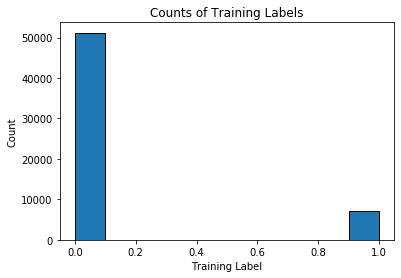

In [11]:
train_labels = np.array(y_train.astype(np.int32)).reshape((-1,))
labels = train_labels[:]
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.hist(labels, edgecolor = 'k'); 
plt.xlabel('Training Label'); plt.ylabel('Count'); plt.title('Counts of Training Labels');

In [130]:
def objective(space):
    # Instantiate the classifier
    clf = xgb.XGBClassifier(n_estimators =1000,colsample_bytree=space['colsample_bytree'],
                            learning_rate = .3,
                            max_depth = int(space['max_depth']),
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            gamma = space['gamma'],
                            reg_lambda = space['reg_lambda'],
                            scale_pos_weight = space['scale_pos_weight'])
    eval_set  = [( X_train, y_train), ( X_test, y_test)]
    
    # Fit the classsifier
    clf.fit(X_train, y_train,
            eval_set=eval_set, eval_metric="logloss",
            early_stopping_rounds=10,verbose=False)
    
    # Predict on Cross Validation data
    pred = clf.predict(X_test)
    
    # Calculate our Metric - accuracy
    #accuracy = accuracy_score(y_test, pred>0.5)
    # Calculate our Metric - roc_auc_score
    prec = precision_score(y_test, pred>0.5)
    
    # return needs to be in this below format. We use negative of accuracy since we want to maximize it.
    return {'loss': -prec, 'status': STATUS_OK }

In [131]:
space = {'max_depth': hp.quniform("x_max_depth", 4, 16, 1),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.7, 1),
        'gamma' : hp.uniform ('x_gamma', 0.1,0.5),
        'colsample_bytree' : hp.uniform ('x_colsample_bytree', 0.7, 1),
        'reg_lambda' : hp.uniform ('x_reg_lambda', 0,1),
        'scale_pos_weight' : hp.uniform ('x_scale_pos_weight', 0, 100)
        }

In [132]:
#Lets run the grid and find are best parameters.
MAX_EVALS = 100

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=MAX_EVALS,
            trials=trials)
print(best)

 67%|██████▋   | 67/100 [11:48:19<5:49:56, 636.27s/it, best loss: -0.9488817891373802]  

/Users/chandlervaughn/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



100%|██████████| 100/100 [20:24:14<00:00, 1400.95s/it, best loss: -0.9488817891373802]  
{'x_colsample_bytree': 0.7606293449729535, 'x_gamma': 0.31752130869892964, 'x_max_depth': 11.0, 'x_min_child': 1.0, 'x_reg_lambda': 0.0043530564635899036, 'x_scale_pos_weight': 0.12321737756291254, 'x_subsample': 0.9984833113503974}


In [75]:
#Train with found / optimized parameters
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

clf = xgb.XGBClassifier(n_estimators =1000,colsample_bytree=0.7606293449729535,
                        learning_rate = 0.3,
                        max_depth = 11,
                        min_child_weight = 1,
                        subsample = 0.9984833113503974,
                        gamma = 0.31752130869892964,
                        reg_lambda = 0.0043530564635899036,
                        scale_pos_weight = 0.12321737756291254)

eval_set  = [( X_train, y_train), ( X_test, y_test)]
    
# Fit the classsifier
clf.fit(X_train, y_train,
        eval_set=eval_set, eval_metric="logloss",
        early_stopping_rounds=10,verbose=False)
    
# Predict on Cross Validation data
pred = clf.predict(X_test)
    
# Calculate our Metric - accuracy
accuracy = accuracy_score(y_test, pred>0.5)
roc_auc = roc_auc_score(y_test, pred>0.5)
prec = precision_score(y_test, pred)
confusion = confusion_matrix(y_test, pred)

In [76]:
def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, pos_label=1)

print('Best ROC-AUC:' + str(roc_auc))
print('Best Accuracy:' + str(accuracy))
print('Best Precision:' + str(prec))
print('Best Recall:', recall_score(y_test, pred))
print('F1 Score:', f1_score(np.array(y_test), np.array(pred)))
print('F2 Score:', f2_score(np.array(y_test), np.array(pred)))
confusion

Best ROC-AUC:0.5799155467960916
Best Accuracy:0.8958005069534836
Best Precision:0.9506578947368421
Best Recall: 0.16100278551532032
F1 Score: 0.2753692234397332
F2 Score: 0.19307856761090325


array([[12787,    15],
       [ 1506,   289]])

### Model 2: ADABoostClassifier Grid Search

For ADABoost we performed a similar grid search leveraging the DecisionTreeClassifier as a base classifier. Our wide search space included the following:

* Criterion - gini | entropy
* Class Weight - None | Balanced
* Algorithm - SAMME | SAMME.R
* Estimators - Discrete uniform distribution between 10 and 500, in increments of 10
* Min Smaples Split - Continuous uniform distribution between 0.0001, and 1
* Min Samples Leaf - Discrete uniform distribution between 1 and 100, in increments of 1
* Min Weight Fraction Leaf - Continuous uniform distribution between 0.0001, and 0.5
* Max Leaf Nodes - Discrete uniform distribution between 1 and 1000, in increments of 1

Using Precision as our guide, we were able to converge to a final model with a Precision of 84.7% and a AUC of 0.517. A confusion matrix is provided below to visualize the classification output for the model. 

| ADABoost Classifier  |
|-------------------------|

| | |
|----------------|----------------------|
| **Best ROC-AUC**   | 0.5165620230822221   |
| **Best Accuracy**  | 0.880454887990683    |
| **Best Precision** | 0.8472222222222222   |
| **Best Recall**    | 0.033983286908077996 |
| **F1 Score**       | 0.06534547402249599  |
| **F2 Score**       | 0.04205736348593491  |
| **F0.5 Score**     | 0.14642342774843972  |
| **MCC**            | 0.15527094649886194  |

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from hyperopt import STATUS_OK
#ITERATION = None

def objective(space):
    global ITERATION
    i = 0
    if i == 0:
        ITERATION = i
        i = 1
        
    ITERATION += 1
    # Instantiate the classifier
    clf = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=((space['min_samples_split'])),
                                                    min_samples_leaf=(int(space['min_samples_leaf'])),
                                                    min_weight_fraction_leaf=(space['min_weight_fraction_leaf']),
                                                    max_leaf_nodes=(int(space['max_leaf_nodes'])),
                                                    criterion=((space['criterion'])),
                                                    class_weight=((space['class_weight']))),
                             n_estimators = int((space['n_estimators'])),
                             learning_rate = (space['learning_rate']),
                             algorithm = (space['algorithm']),
                             random_state=50)
    

    eval_set  = [( X_train, y_train), ( X_test, y_test)]
    
    # Fit the classsifier
    clf.fit(X_train, y_train)
    
        
    # Predict on Cross Validation data
    try:
        pred = clf.predict(X_test)
        prec = precision_score(y_test, pred>0.5)
    except:
        print("precision undefined setting to zero")
        prec = 0
    
    return {'loss': -prec, 'params': space, 'iteration': ITERATION, 'status': STATUS_OK}

In [58]:
space = {
         'criterion': hp.choice('x_criterion', ["gini", "entropy"]),
         'class_weight': hp.choice('class_weight', [None, 'balanced']),
         'min_samples_split': hp.uniform('x_min_samples_split', 0.0001, 1.0),
         'min_samples_leaf': hp.quniform('x_min_samples_leaf', 1, 100, 1),
         'min_weight_fraction_leaf': hp.uniform('x_min_weight_fraction_leaf', 0.0001, 0.5),
         'max_leaf_nodes': hp.quniform('x_max_leaf_nodes', 1, 1000, 1),
         'n_estimators': hp.quniform("x_n_estimators", 10, 500, 10),
         'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.5)),
         'algorithm': hp.choice("x_algorithm", ['SAMME', "SAMME.R"])
        }

In [ ]:
#Lets run the grid and find are best parameters.
MAX_EVALS = 100

trials = Trials()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=MAX_EVALS,
            trials=trials)
print(best)

In [ ]:
#Precision
#100%|██████████| 100/100 [31:27:15<00:00, 1082.17s/it, best loss: -0.8472222222222222] 
#{'class_weight': 0, 'learning_rate': 0.27016509124545907, 'x_algorithm': 1, 'x_criterion': 0, 
#'x_max_leaf_nodes': 891.0, 'x_min_samples_leaf': 81.0, 'x_min_samples_split': 0.4485326510349782, 
#            'x_min_weight_fraction_leaf': 0.3558421449059902, 'x_n_estimators': 40.0}

In [60]:
loss_res = []
param_results = []
iteration_num = []
results = pd.DataFrame(trials.results)

for index_num, loss, params, iteration, status in results.itertuples():
    iteration = index_num+1
    iteration_num.append(iteration)
    loss_res.append(-loss)
    param_results.append(params)

merge_df = pd.merge(pd.Series(loss_res, name='precision'),
                 pd.DataFrame(param_results), 
                 left_index=True, right_index=True, 
                 copy=True)

merge2_df = pd.merge(pd.Series(iteration_num, name='iteration'),
                  pd.DataFrame(merge_df), 
                  left_index=True, right_index=True, 
                  copy=True)
merge2_df

,iteration,precision,algorithm,class_weight,criterion,learning_rate,max_leaf_nodes,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators
0,1,0.182824,SAMME,balanced,gini,0.068602,839.0,56.0,0.129201,0.197259,440.0
1,2,0.000000,SAMME,None,gini,0.005759,375.0,40.0,0.489077,0.376565,460.0
2,3,0.000000,SAMME,None,entropy,0.033102,570.0,37.0,0.129390,0.327017,80.0
3,4,0.000000,SAMME,None,gini,0.017696,430.0,35.0,0.281558,0.412835,100.0
4,5,0.182824,SAMME,balanced,entropy,0.006940,251.0,37.0,0.213654,0.308179,340.0
...,...,...,...,...,...,...,...,...,...,...,...
95,96,0.000000,SAMME.R,None,gini,0.011404,755.0,54.0,0.396729,0.171465,320.0
96,97,0.703125,SAMME.R,None,entropy,0.054555,898.0,43.0,0.080831,0.031987,20.0
97,98,0.169056,SAMME.R,balanced,gini,0.109275,259.0,87.0,0.364169,0.471041,430.0
98,99,0.745946,SAMME.R,None,gini,0.134212,947.0,75.0,0.338285,0.359753,180.0


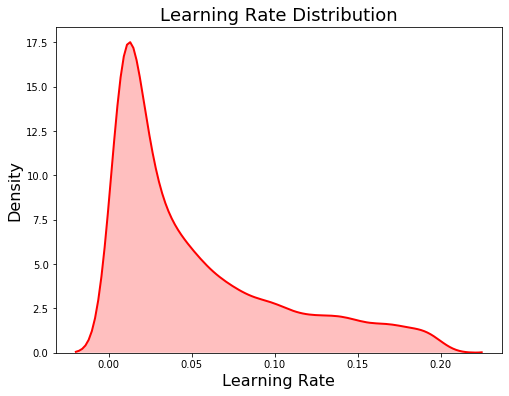

In [48]:
from hyperopt.pyll.stochastic import sample
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
learning_rate_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    learning_rate_dist.append(sample(space)['learning_rate'])
    
plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18); 
plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

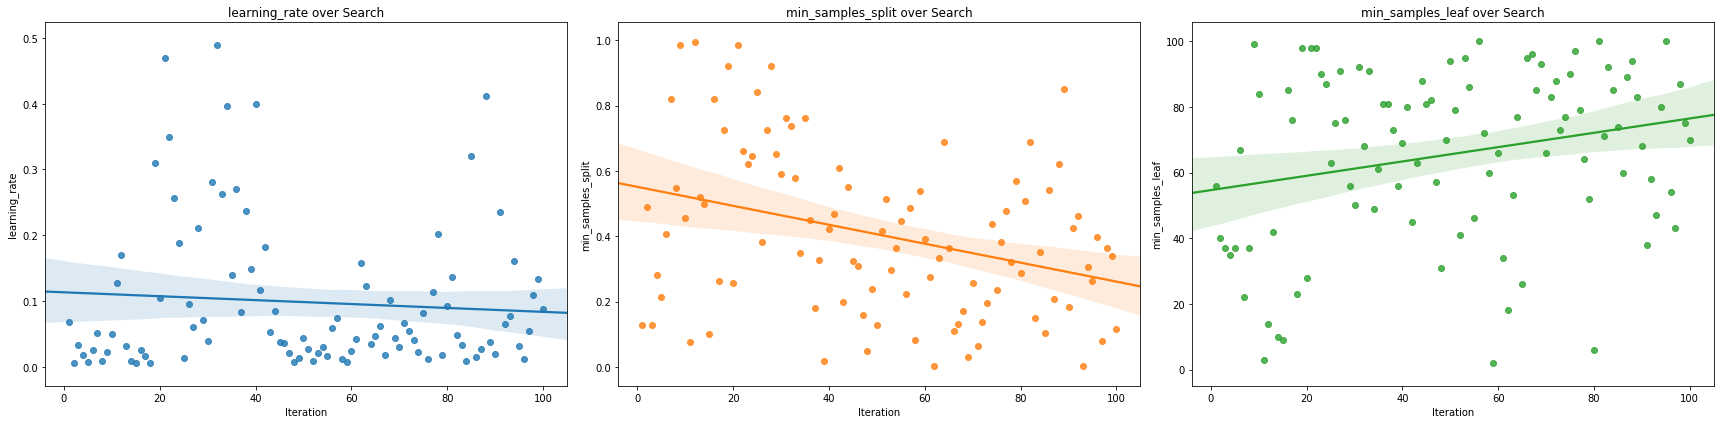

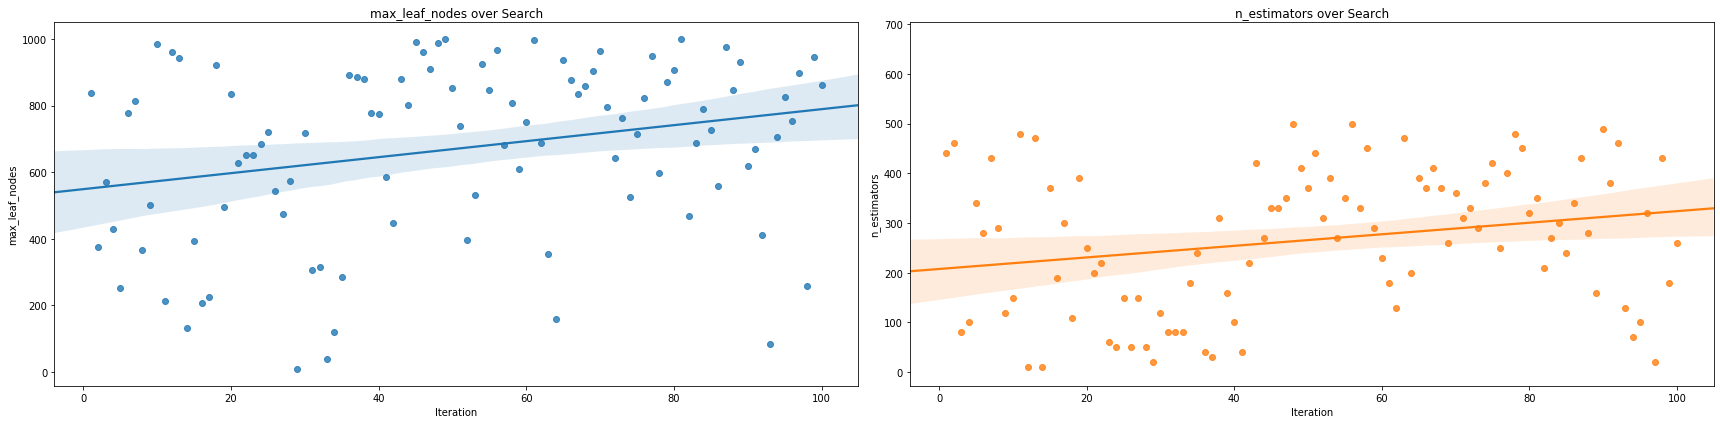

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
                        
fig, axs = plt.subplots(1, 3, figsize = (24, 6))
i = 0

# Plot of 3 hyperparameters
for i, hyper in enumerate(['learning_rate', 'min_samples_split', 'min_samples_leaf']):
    
        # Scatterplot
        sns.regplot('iteration', hyper, data = merge2_df, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

fig, axs = plt.subplots(1, 2, figsize = (24, 6))
i = 0

# Plot of 2 hyperparameters
for i, hyper in enumerate(['max_leaf_nodes', 'n_estimators']):
    
        # Scatterplot
        sns.regplot('iteration', hyper, data = merge2_df, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

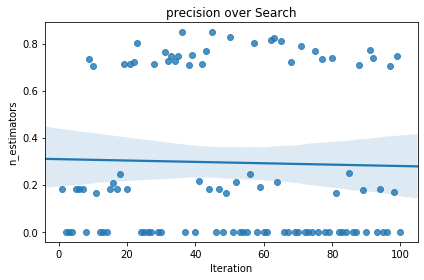

In [62]:
fig, axs = plt.subplots()

sns.regplot('iteration', 'precision', data = merge2_df)
axs.set(xlabel = 'Iteration', ylabel = '{}'.format('precision'), title = '{} over Search'.format('precision'));

plt.tight_layout()

In [ ]:
#Retraining the model with specific BEST parameters.

#Precision
#100%|██████████| 100/100 [31:27:15<00:00, 1082.17s/it, best loss: -0.8472222222222222] 
#{'class_weight': 0, 'learning_rate': 0.27016509124545907, 'x_algorithm': 1, 'x_criterion': 0, 'x_max_leaf_nodes': 891.0, 'x_min_samples_leaf': 81.0, 
#'x_min_samples_split': 0.4485326510349782, 'x_min_weight_fraction_leaf': 0.3558421449059902, 'x_n_estimators': 40.0}

In [77]:
#Train with found / optimized parameters
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

clf = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=0.4485326510349782,
                                                min_samples_leaf=81,
                                                min_weight_fraction_leaf=0.3558421449059902,
                                                max_leaf_nodes=891,
                                                criterion='gini'),
                         n_estimators = 40,
                         learning_rate = 0.27016509124545907,
                         algorithm = 'SAMME.R',
                         random_state=50)

       
eval_set  = [( X_train, y_train), ( X_test, y_test)]

# Fit the classsifier
clf.fit(X_train, y_train)

try:
    pred = clf.predict(X_test)
    prec = precision_score(y_test, pred>0.5)
except:
    print("precision undefined setting to zero")
    prec = 0
    
# Calculate our Metric - accuracy
accuracy = accuracy_score(y_test, pred>0.5)
roc_auc = roc_auc_score(y_test, pred>0.5)
prec = precision_score(y_test, pred)
confusion = confusion_matrix(y_test, pred)

In [84]:

def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, pos_label=1)

def f_half_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=0.5, pos_label=1)


print('Best ROC-AUC:' + str(roc_auc))
print('Best Accuracy:' + str(accuracy))
print('Best Precision:' + str(prec))
print('Best Recall:', recall_score(y_test, pred))
print('F1 Score:', f1_score(np.array(y_test), np.array(pred)))
print('F2 Score:', f2_score(np.array(y_test), np.array(pred)))
print('F0.5 Score:', f_half_score(np.array(y_test), np.array(pred)))
print('MCC:', matthews_corrcoef(np.array(y_test), np.array(pred)))
confusion

Best ROC-AUC:0.5165620230822221
Best Accuracy:0.880454887990683
Best Precision:0.8472222222222222
Best Recall: 0.033983286908077996
F1 Score: 0.06534547402249599
F2 Score: 0.04205736348593491
F0.5 Score: 0.14642342774843972
MCC: 0.15527094649886194


array([[12791,    11],
       [ 1734,    61]])

### Model 3: DistributedRandomForest (DRF)

Random Forest is an ensemble learning method used for classification and regression where a majority voting pattern is used to determine the class label for unlabeled instances. The ensembles tend to offer better results in terms of both speed and accuracy. H20 Distributed Random Forest (DRF) generates a forest of classification or regression tree versus a single tree. DRF classification takes the average prediction of all trees to make a final class prediction.

The ability to fetch and inspect each tree individually is important aspect of model consideration where no tree is lost, and internal structure of the object fetched which contains all the information available about every node in the tree.

We employed a 3-tier approach to define our DRF model with AutoML leaderboard technique in H2O environment was considered for underlying training, tuning and selection activities for a binary (IsBadBuy) classification.

We define our base model by specifying number of trees and random number generator seed for randomization with default stopping metrics within H2O environment.

Building onto base model we consider introducing cross-validation and binary classification to build twice as many trees hoping to achieve higher accuracy while sacrificing speed. Furthermore, we introduce the relative tolerance for the metric-based stopping to stop further training in case the improvement is less. Since we grappled with imbalanced in our dataset, we tried to tackle any oversampling of the minority classes by balancing the class distribution.

Shifting gears away from parameterizing of model building, we employed H2O AutoML interface which is designed to have as few parameters as possible while limiting the number of total models (max_models) that are trained with the goal of finding the “best” model with a desired stopping metric (aucpr - area under the precision-recall curve) and algorithm (DRF) preference.

After reviewing results of both approach (base (2) and leaderboard (8)) of models that were trained in the process, we selected the best model trained by AutoML leaderboard as a foundation to our final model.

| Discrete Random Forest  |
|-------------------------|

|  |             |
|------------------------|-------------|
| **Best ROC-AUC**          | 0.729951047 |
| **Best Accuracy**          | 0.269225    |
| **Best Precision**         | 0.739344    |
| **Best Recall**            | 0.00001    |
| **F1 Score**               | 0.10626     |
| **F2 Score**               | 0.47057     |

In [84]:
h2o_frame = h2o.H2OFrame(kick_data)

#Set variables and columns
y = 'IsBadBuy'
x = h2o_frame.col_names
try:
    x.remove('state') #duplicate column
except:
    print("Columns not found. Drop has already been performed.")

try:
    x.remove('zip') #duplicate column
except:
    print("Columns not found. Drop has already been performed.")
    
try:
    x.remove('SubModel')
except:
    print("Columns not found. Drop has already been performed.")

x.remove(y)
x.remove('PurchDate')
x.remove('VehYear')
x.remove('VNZIP1')
x.remove('WheelTypeID')
x.remove('Nationality')
x.remove('TopThreeAmericanName') 
x.remove('Trim')

print(" ")
print("Response = " + str(y))
print(" ")
print("Predictors = " + str(x))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Columns not found. Drop has already been performed.
Columns not found. Drop has already been performed.
 
Response = IsBadBuy
 
Predictors = ['Auction', 'VehicleAge', 'Make', 'Model', 'Color', 'Transmission', 'WheelType', 'VehOdo', 'Size', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionRetailAveragePrice', 'BYRNO', 'VNST', 'VehBCost', 'IsOnlineSale', 'WarrantyCost', 'Mileage', 'Luxury', 'Axle', 'Cylinder']


In [85]:
train,test,valid = h2o_frame.split_frame(ratios=[.7, .15])
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
valid[y] = valid[y].asfactor()

train[continuous_features] = train[continuous_features].scale(center=True, scale=True)

In [86]:

########## DRF MODEL CODE #################

# ### Distributed Random Forest #2
folds = 10
drf_IsBadBuy_Final = H2ORandomForestEstimator(
    model_id="drf_IsBadBuy_Final",
    ntrees=47,
    max_depth=20,
    stopping_rounds=2,
    stopping_tolerance=0.01,
    score_each_iteration=True,
    seed=3000000,
    nfolds = folds,
    keep_cross_validation_predictions = True,
    binomial_double_trees = True,
    stopping_metric = "AUCPR",
    balance_classes = True)


drf_IsBadBuy_Final.train(x=x, y=y, training_frame=train, validation_frame = valid)




drf Model Build progress: |███████████████████████████████████████████████| 100%


In [87]:
# calling the model to get an overview of model statistics

drf_IsBadBuy_Final

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  drf_IsBadBuy_Final


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,20.0,40.0,4173405.0,20.0,20.0,20.0,4150.0,5268.0,4856.2




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.07774473331903829
RMSE: 0.2788274256938121
LogLoss: 0.26627289698411427
Mean Per-Class Error: 0.014480998442610415
AUC: 0.9968058280218162
pr_auc: 0.7098835439750082
Gini: 0.9936116560436323

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19618240570445145: 


,,0,1,Error,Rate
0,0,43978.0,801.0,0.0179,(801.0/44779.0)
1,1,496.0,44293.0,0.0111,(496.0/44789.0)
2,Total,44474.0,45094.0,0.0145,(1297.0/89568.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.196182,0.985570,293.0
1,max f2,0.157797,0.990380,304.0
2,max f0point5,0.224039,0.985648,285.0
3,max accuracy,0.196182,0.985519,293.0
4,max precision,0.534965,0.996132,170.0
5,max recall,0.000009,1.000000,399.0
6,max specificity,1.000000,0.998213,0.0
7,max absolute_mcc,0.196182,0.971061,293.0
8,max min_per_class_accuracy,0.211136,0.984524,289.0
9,max mean_per_class_accuracy,0.196182,0.985519,293.0



Gains/Lift Table: Avg response rate: 50.01 %, avg score: 37.33 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.143887,1.000000,1.987298,1.987298,0.993793,1.000000,0.993793,1.000000,0.285947,0.285947,98.729790,98.729790
1,,2,0.150005,0.965183,1.999710,1.987804,1.000000,0.978209,0.994046,0.999111,0.012234,0.298181,99.970979,98.780410
2,,3,0.200007,0.829051,1.994799,1.989553,0.997544,0.891152,0.994921,0.972122,0.099743,0.397924,99.479869,98.955275
3,,4,0.299999,0.629521,1.995691,1.991599,0.997990,0.726003,0.995944,0.890088,0.199554,0.597477,99.569117,99.159873
4,,5,0.400002,0.453502,1.985423,1.990055,0.992856,0.541667,0.995172,0.802980,0.198549,0.796026,98.542296,99.005475
5,,6,0.500006,0.210494,1.885415,1.969126,0.942844,0.349084,0.984706,0.712199,0.188548,0.984574,88.541515,96.912636
6,,7,0.599998,0.057248,0.150921,1.666115,0.075472,0.099887,0.833178,0.610155,0.015091,0.999665,-84.907851,66.611477
7,,8,0.700247,0.030609,0.001559,1.427813,0.000780,0.042078,0.714010,0.528827,0.000156,0.999821,-99.844121,42.781307
8,,9,0.800161,0.015543,0.000000,1.249526,0.000000,0.022597,0.624854,0.465616,0.000000,0.999821,-100.000000,24.952568
9,,10,1.000000,0.000000,0.000894,1.000000,0.000447,0.003426,0.500073,0.373252,0.000179,1.000000,-99.910632,0.000000




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.09919555045599526
RMSE: 0.31495325122309065
LogLoss: 0.38091738784146073
Mean Per-Class Error: 0.37148845789290075
AUC: 0.6682478936534801
pr_auc: 0.3918501205524311
Gini: 0.3364957873069603

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11431359315458753: 


,,0,1,Error,Rate
0,0,9503.0,74.0,0.0077,(74.0/9577.0)
1,1,978.0,312.0,0.7581,(978.0/1290.0)
2,Total,10481.0,386.0,0.0968,(1052.0/10867.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.114314,0.372315,90.0
1,max f2,0.025151,0.417163,333.0
2,max f0point5,0.133875,0.562174,81.0
3,max accuracy,0.150049,0.904850,71.0
4,max precision,0.718916,1.000000,0.0
5,max recall,0.000000,1.000000,399.0
6,max specificity,0.718916,1.000000,0.0
7,max absolute_mcc,0.150049,0.420750,71.0
8,max min_per_class_accuracy,0.042277,0.600775,258.0
9,max mean_per_class_accuracy,0.066619,0.628512,171.0



Gains/Lift Table: Avg response rate: 11.87 %, avg score:  4.75 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010030,0.319254,8.192177,8.192177,0.972477,0.423708,0.972477,0.423708,0.082171,0.082171,719.217694,719.217694
1,,2,0.021257,0.221295,7.595438,7.877016,0.901639,0.259903,0.935065,0.337196,0.085271,0.167442,659.543779,687.701601
2,,3,0.030459,0.145672,6.402264,7.431471,0.760000,0.178757,0.882175,0.289329,0.058915,0.226357,540.226357,643.147146
3,,4,0.040029,0.102020,2.106008,6.158257,0.250000,0.117299,0.731034,0.248200,0.020155,0.246512,110.600775,515.825715
4,,5,0.050152,0.089561,1.148732,5.147160,0.136364,0.094464,0.611009,0.217171,0.011628,0.258140,14.873150,414.716023
5,,6,0.100028,0.071609,1.290027,3.223916,0.153137,0.078391,0.382705,0.147972,0.064341,0.322481,29.002689,222.391619
6,,7,0.149995,0.063759,1.070457,2.506537,0.127072,0.067428,0.297546,0.121141,0.053488,0.375969,7.045698,150.653683
7,,8,0.200055,0.057657,0.960092,2.119570,0.113971,0.060580,0.251610,0.105987,0.048062,0.424031,-3.990823,111.956990
8,,9,0.299991,0.050166,0.861020,1.700311,0.102210,0.053716,0.201840,0.088574,0.086047,0.510078,-13.898026,70.031055
9,,10,0.400110,0.043142,0.727812,1.456962,0.086397,0.046573,0.172953,0.078064,0.072868,0.582946,-27.218850,45.696212




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.09665782590559804
RMSE: 0.3108984173417389
LogLoss: 0.4477906001228018
Mean Per-Class Error: 0.3340811871619809
AUC: 0.7299510471308979
pr_auc: 0.4086370039517885
Gini: 0.45990209426179574

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10625970617767704: 


,,0,1,Error,Rate
0,0,42535.0,2247.0,0.0502,(2247.0/44782.0)
1,1,4279.0,2086.0,0.6723,(4279.0/6365.0)
2,Total,46814.0,4333.0,0.1276,(6526.0/51147.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.106260,0.389979,216.0
1,max f2,0.032319,0.470570,323.0
2,max f0point5,0.231129,0.525988,142.0
3,max accuracy,0.269225,0.896455,128.0
4,max precision,0.739344,0.956679,25.0
5,max recall,0.000005,1.000000,399.0
6,max specificity,1.000000,0.999821,0.0
7,max absolute_mcc,0.255783,0.386744,132.0
8,max min_per_class_accuracy,0.034809,0.658814,318.0
9,max mean_per_class_accuracy,0.046509,0.665919,295.0



Gains/Lift Table: Avg response rate: 12.44 %, avg score:  5.16 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010010,0.598688,7.486351,7.486351,0.931641,0.805540,0.931641,0.805540,0.074941,0.074941,648.635083,648.635083
1,,2,0.020001,0.443074,7.076416,7.281584,0.880626,0.522293,0.906158,0.664055,0.070699,0.145640,607.641625,628.158390
2,,3,0.030012,0.286549,5.807023,6.789743,0.722656,0.362471,0.844951,0.563461,0.058130,0.203771,480.702266,578.974328
3,,4,0.040002,0.197437,3.443856,5.954089,0.428571,0.236366,0.740958,0.481767,0.034407,0.238178,244.385591,495.408910
4,,5,0.050013,0.155873,2.511145,5.264962,0.312500,0.173185,0.655199,0.420003,0.025137,0.263315,151.114493,426.496189
5,,6,0.100006,0.094897,1.719010,3.492332,0.213923,0.118367,0.434604,0.269214,0.085939,0.349254,71.900981,249.233247
6,,7,0.149999,0.072982,1.385893,2.790277,0.172468,0.082581,0.347237,0.207011,0.069285,0.418539,38.589274,179.027741
7,,8,0.200012,0.059827,1.225140,2.398917,0.152463,0.065828,0.298534,0.171709,0.061273,0.479811,22.514030,139.891664
8,,9,0.299998,0.043439,1.092058,1.963354,0.135901,0.050918,0.244330,0.131450,0.109191,0.589002,9.205834,96.335398
9,,10,0.400004,0.032889,0.887615,1.694406,0.110459,0.037808,0.210861,0.108039,0.088767,0.677769,-11.238513,69.440606




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,accuracy,0.86780465,0.015815688,0.8842229,0.88393724,0.8451817,0.8607893,0.8674699,0.8392188,0.8834332,0.86708736,0.8690639,0.87764204
1,auc,0.7302641,0.0100136725,0.7140877,0.7315458,0.7242415,0.7306922,0.7203648,0.7364849,0.7484331,0.7330433,0.73971534,0.7240325
2,err,0.13219537,0.015815688,0.11577708,0.116062775,0.15481833,0.13921069,0.13253012,0.16078122,0.11656679,0.13291264,0.1309361,0.12235796
3,err_count,675.7,76.61455,590.0,599.0,784.0,709.0,682.0,815.0,603.0,674.0,670.0,631.0
4,f0point5,0.4391227,0.043011528,0.50254095,0.46860573,0.38151965,0.41138095,0.43486664,0.3677531,0.48812664,0.44117647,0.44975537,0.44550174
5,f1,0.39720416,0.01591968,0.37632135,0.4039801,0.37678856,0.39036974,0.3975265,0.38490567,0.42406878,0.40669015,0.4163763,0.39501438
6,f2,0.36636913,0.027205212,0.3007773,0.35501924,0.37217337,0.37140054,0.36609176,0.40373653,0.37487334,0.37720445,0.38760948,0.35480538
7,lift_top_group,7.536625,0.36618012,6.9042134,7.7437778,6.959868,7.5965323,7.255945,7.8437138,7.8021827,7.588999,7.79887,7.8721485
8,logloss,0.44776094,0.020126062,0.45950836,0.4616094,0.46913108,0.43697223,0.44232088,0.42884135,0.4461066,0.4445482,0.41024223,0.478329
9,max_per_class_error,0.6501656,0.03870289,0.7347243,0.671521,0.63084114,0.64025354,0.6522411,0.5826514,0.6520376,0.6401869,0.62945735,0.66774195



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2019-10-26 22:22:42,1 min 38.392 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-10-26 22:22:43,1 min 38.727 sec,1.0,0.351662,1.668891,0.966273,0.339211,1.904331,0.058753,0.430065,6.019605,0.647548,0.190427,4.631863,0.113003
2,,2019-10-26 22:22:43,1 min 38.976 sec,2.0,0.330648,1.461289,0.971789,0.343387,1.913743,0.049012,0.328333,2.252884,0.659400,0.213935,4.994779,0.118524
3,,2019-10-26 22:22:43,1 min 39.263 sec,3.0,0.324303,1.236096,0.974475,0.379997,1.922047,0.047159,0.316219,1.521370,0.645546,0.250559,6.500024,0.161498
4,,2019-10-26 22:22:44,1 min 39.574 sec,4.0,0.319854,1.054011,0.977097,0.418660,1.927841,0.044856,0.313404,1.041671,0.669826,0.296856,7.245845,0.139137
5,,2019-10-26 22:22:44,1 min 39.916 sec,5.0,0.310702,0.865405,0.980830,0.458573,1.938148,0.040923,0.311516,0.782471,0.636724,0.295718,7.691507,0.106929
6,,2019-10-26 22:22:44,1 min 40.230 sec,6.0,0.299735,0.731849,0.983845,0.479209,1.946273,0.036227,0.312923,0.736442,0.644656,0.336510,8.054556,0.119076
7,,2019-10-26 22:22:45,1 min 40.546 sec,7.0,0.297132,0.627194,0.985675,0.513358,1.951313,0.034368,0.312135,0.615783,0.648477,0.343553,7.966913,0.112266
8,,2019-10-26 22:22:45,1 min 40.866 sec,8.0,0.294393,0.539809,0.987972,0.542009,1.957653,0.030686,0.311683,0.530321,0.668209,0.361544,7.960323,0.106929
9,,2019-10-26 22:22:45,1 min 41.210 sec,9.0,0.289224,0.468513,0.989903,0.565874,1.963510,0.026880,0.311813,0.502213,0.667820,0.368725,8.044000,0.100764



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,WheelType,78640.531250,1.000000,0.157400
1,Model,78497.648438,0.998183,0.157114
2,VNST,54957.890625,0.698849,0.109999
3,Color,44523.597656,0.566166,0.089115
4,VehBCost,32897.500000,0.418328,0.065845
5,VehOdo,31992.480469,0.406819,0.064033
6,MMRAcquisitionAuctionAveragePrice,30185.669922,0.383844,0.060417
7,Make,26516.044922,0.337180,0.053072
8,VehicleAge,25097.419922,0.319141,0.050233
9,MMRAcquisitionRetailAveragePrice,24297.218750,0.308966,0.048631


In [88]:
## Final Prediction for Model 2
final_drf_predictions = drf_IsBadBuy_Final.predict(test)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [89]:
final_drf_predictions

predict,p0,p1
0,0.962029,0.0379712
0,0.970955,0.0290452
0,0.952826,0.0471742
0,0.980105,0.019895
0,0.968811,0.0311886
0,0.96344,0.0365603
0,0.977252,0.0227476
0,0.959816,0.040184
0,0.961021,0.0389786
0,0.969107,0.0308932


In [90]:
# test set accuracy
(final_drf_predictions['predict']==test['IsBadBuy']).as_data_frame(use_pandas=True).mean()

predict    0.900173
dtype: float64

In [93]:
perf.gini()

0.3364957873069603

In [91]:
drf_IsBadBuy_Final.gini(train=True, valid=True, xval=False)

{'train': 0.9936116560436323, 'valid': 0.3364957873069603}

In [94]:
perf.mcc()

[[0.15004887323048383, 0.4207498340567714]]

In [95]:
drf_IsBadBuy_Final.mcc(train=True, valid=True, xval=False)

{'train': [[0.19618240570445145, 0.9710612618701598]],
 'valid': [[0.15004887323048383, 0.4207498340567714]]}

In [96]:
perf.F1()

[[0.11431359315458753, 0.3723150357995227]]

In [97]:
drf_IsBadBuy_Final.F1(train=True, valid=True, xval=False)

{'train': [[0.19618240570445145, 0.9855701300579643]],
 'valid': [[0.11431359315458753, 0.3723150357995227]]}

In [98]:
perf.F0point5()
drf_IsBadBuy_Final.F0point5(train=True, valid=True, xval=False)


{'train': [[0.22403917100527915, 0.9856479716547439]],
 'valid': [[0.13387456490785601, 0.5621742367833209]]}

In [99]:
perf.F2()
drf_IsBadBuy_Final.F2(train=True, valid=True, xval=False)

{'train': [[0.15779711002703614, 0.9903801293017261]],
 'valid': [[0.02515066085279234, 0.41716284608514437]]}

In [100]:
perf.accuracy()
drf_IsBadBuy_Final.accuracy(train=True, valid=True, xval=False)

{'train': [[0.19618240570445145, 0.9855193819221151]],
 'valid': [[0.15004887323048383, 0.9048495444925002]]}

In [101]:
drf_IsBadBuy_Final.logloss(train=True, valid=True, xval=False)

{'train': 0.26627289698411427, 'valid': 0.38091738784146073}

In [102]:
perf.auc()
drf_IsBadBuy_Final.auc(train=True, valid=True, xval=False)

{'train': 0.9968058280218162, 'valid': 0.6682478936534801}

In [103]:
perf.pr_auc()
drf_IsBadBuy_Final.pr_auc(train=True, valid=True, xval=False)

{'train': 0.7098835439750082, 'valid': 0.3918501205524311}

### Classification Modeling Summary


| **Classification Model Summary** |
|----------------------------------|

| Metric   | XGBoost    | ADABoost | Discrete Random Forest            |
|-----------|-------------|------------------------|-------------|
| Precision | 0.950657895 | 0.847222222            | 0.73934   |
| Recall    | 0.161002786 | 0.033983287            | 0.00001    |
| Accuracy  | 0.895800507 | 0.880454888            | 0.26923    |
| ROC-AUC   | 0.579915547 | 0.516562023            | 0.72995 |
| F1        | 0.275369223 | 0.065345474            | 0.10626     |
| F2        | 0.193078568 | 0.042057363            | 0.47057     |

## 3.3.2 Regression Models

### **Model 1:** Generalized Linear Model (Gaussian regression)

H2O’s Gaussian GLM corresponds to the Gaussian family regression model. IT is the simplest example of GLM but has several advantages over the other two models. Specifically, it is faster and requires more stable computations.
To get the best possible model, after establishing a baseline model, we set our model to perform a lambda search based on a 100 k-fold cross validation in order to get the best possible model. Lambda search enables efficient and automatic search for optimal value of the lambda parameter. When lambda search is enabled, GLM will first fit a model with maximum regularization strength and then keep decreasing it until overfitting. The resulting model will be based on the best lambda value that is selected based on performance of cross validation. Based on the lambda search results, we eliminated any predictors that did not provide value and reran the model without regularization in order to compute p-values for each parameter and to ensure that all collinear columns have been removed.
Final predictors selected in our final model were 'VehicleAge', 'Color', 'WheelType', 'VehOdo', 'Size', 'MMRAcquisitionRetailAveragePrice', 'BYRNO', 'VehBCost', 'IsOnlineSale', 'WarrantyCost', 'Mileage', 'Axle', and 'Cylinder'

In [13]:
#Set variables and columns
Price_y = 'MMRAcquisitionAuctionAveragePrice'
Price_x = h2o_frame.col_names
try:
    Price_x.remove('state') #duplicate column
    Price_x.remove('zip') #duplicate column
    Price_x.remove('SubModel')
except:
    print("Columns not found. Drop has already been performed.")

Price_x.remove(Price_y)
Price_x.remove('PurchDate')
Price_x.remove('VehYear')
Price_x.remove('VNZIP1')
Price_x.remove('WheelTypeID')
Price_x.remove('Nationality')
Price_x.remove('model_short') 
Price_x.remove('TopThreeAmericanName') 
Price_x.remove('Trim')
Price_x.remove('IsBadBuy')
Price_x.remove('Transmission')
Price_x.remove('Auction')
Price_x.remove('Luxury')
Price_x.remove('Make')
Price_x.remove('VNST')
#Price_x.remove("MMRAcquisitionRetailAveragePrice")

print("Response = " + str(Price_y))
print("Predictors = " + str(Price_x))

Columns not found. Drop has already been performed.
Response = MMRAcquisitionAuctionAveragePrice
Predictors = ['VehicleAge', 'Color', 'WheelType', 'VehOdo', 'Size', 'MMRAcquisitionRetailAveragePrice', 'BYRNO', 'VehBCost', 'IsOnlineSale', 'WarrantyCost', 'Mileage', 'Axle', 'Cylinder']


In [14]:
#Outline datasets
train,test,valid = h2o_frame.split_frame(ratios=[.7, .15])
print('Total Dataset: ' + str(h2o_frame.shape))
print('Train: ' + str(train.shape))
print('Validate: ' + str(valid.shape))
print('Test: ' + str(test.shape))

Total Dataset: (72983, 28)
Train: (51159, 28)
Validate: (10822, 28)
Test: (11002, 28)


In [41]:
#perform a regression
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

glm_price = H2OGeneralizedLinearEstimator(family = "gaussian", nfolds = 100,  lambda_ =0, remove_collinear_columns=True, compute_p_values=True)
glm_price.train(x=Price_x, y=Price_y, training_frame=train,validation_frame=valid, model_id="glm_price")

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [35]:
#Display cross-validation Metrics
glm_price.model_performance(xval = True)


ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 0.00044743645164979125
RMSE: 0.021152693720890285
MAE: 0.016625004430075717
RMSLE: 0.01796641220671819
R^2: 0.9060001172175358
Mean Residual Deviance: 0.00044743645164979125
Null degrees of freedom: 51158
Residual degrees of freedom: 51110
Null deviance: 243.5257325426056
Residual deviance: 22.89040142995167
AIC: -249254.02927839162


In [46]:
glm_price

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  glm_price


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,None,48,48,1,py_3_sid_b31b




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.0004464137315930936
RMSE: 0.021128505190691878
MAE: 0.016608074594737433
RMSLE: 0.017946385646473634
R^2: 0.9062149758082918
Mean Residual Deviance: 0.0004464137315930936
Null degrees of freedom: 51158
Residual degrees of freedom: 51110
Null deviance: 243.5152124915418
Residual deviance: 22.838080094571076
AIC: -249371.09891532492

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 0.00043604118507595323
RMSE: 0.02088159919824038
MAE: 0.016389856861952625
RMSLE: 0.017770356464998593
R^2: 0.9087238924600521
Mean Residual Deviance: 0.00043604118507595323
Null degrees of freedom: 10821
Residual degrees of freedom: 10773
Null deviance: 51.6985253303097
Residual deviance: 4.718837704891966
AIC: -52926.683077436515

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 0.0004474191051531274
RMSE: 0.02115228368647526
MAE: 0.01662467778982418
RMSLE: 0.017965976075911095
R^2: 0.90

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid,cv_11_valid,cv_12_valid,cv_13_valid,cv_14_valid,cv_15_valid,cv_16_valid,cv_17_valid,cv_18_valid,cv_19_valid,cv_20_valid,cv_21_valid,cv_22_valid,cv_23_valid,cv_24_valid,cv_25_valid,cv_26_valid,cv_27_valid,cv_28_valid,cv_29_valid,cv_30_valid,cv_31_valid,cv_32_valid,cv_33_valid,cv_34_valid,cv_35_valid,cv_36_valid,cv_37_valid,cv_38_valid,cv_39_valid,cv_40_valid,cv_41_valid,cv_42_valid,cv_43_valid,cv_44_valid,cv_45_valid,cv_46_valid,cv_47_valid,cv_48_valid,cv_49_valid,cv_50_valid,cv_51_valid,cv_52_valid,cv_53_valid,cv_54_valid,cv_55_valid,cv_56_valid,cv_57_valid,cv_58_valid,cv_59_valid,cv_60_valid,cv_61_valid,cv_62_valid,cv_63_valid,cv_64_valid,cv_65_valid,cv_66_valid,cv_67_valid,cv_68_valid,cv_69_valid,cv_70_valid,cv_71_valid,cv_72_valid,cv_73_valid,cv_74_valid,cv_75_valid,cv_76_valid,cv_77_valid,cv_78_valid,cv_79_valid,cv_80_valid,cv_81_valid,cv_82_valid,cv_83_valid,cv_84_valid,cv_85_valid,cv_86_valid,cv_87_valid,cv_88_valid,cv_89_valid,cv_90_valid,cv_91_valid,cv_92_valid,cv_93_valid,cv_94_valid,cv_95_valid,cv_96_valid,cv_97_valid,cv_98_valid,cv_99_valid,cv_100_valid
0,mae,0.016624166,5.1760656E-4,0.016954076,0.016771875,0.016704028,0.017000359,0.016600769,0.016625227,0.016868183,0.016397633,0.016124202,0.017216168,0.017489027,0.017566834,0.016256118,0.017031472,0.016766872,0.016247096,0.01662912,0.016983336,0.01685203,0.016365925,0.01588526,0.016838996,0.015980767,0.015675059,0.015712958,0.016448637,0.017299082,0.015911544,0.017536754,0.0154848965,0.016806426,0.01687274,0.01651809,0.016748872,0.016176369,0.017004954,0.017013608,0.016088955,0.017509086,0.01664434,0.01638728,0.01617049,0.01715969,0.017567711,0.016857382,0.016928453,0.016815718,0.016099963,0.017024044,0.01693365,0.016123459,0.016643506,0.016638529,0.016691858,0.017558213,0.016903732,0.016608413,0.016729116,0.016362749,0.016089628,0.016145183,0.017194334,0.016497862,0.015786326,0.016701454,0.016551876,0.0164835,0.015912773,0.016330926,0.016245624,0.017800413,0.017528344,0.0161486,0.016106682,0.016076388,0.01740484,0.016752394,0.017108455,0.016354028,0.01633849,0.017073853,0.016519194,0.01558053,0.01643608,0.016728865,0.016774787,0.017073954,0.015890097,0.016598048,0.016537484,0.015984826,0.01701471,0.01641485,0.017003069,0.017233873,0.015969861,0.016948031,0.016260842,0.017482746,0.015521032
1,mean_residual_deviance,4.4737195E-4,3.9061175E-5,4.381557E-4,4.267337E-4,4.675438E-4,4.7254353E-4,4.3746963E-4,4.4244961E-4,4.5557256E-4,4.0468547E-4,4.1791328E-4,5.131476E-4,5.207005E-4,5.3553074E-4,4.1560986E-4,4.4754002E-4,4.6447283E-4,4.2737825E-4,4.656247E-4,4.5282952E-4,4.6466797E-4,4.3507564E-4,3.979244E-4,4.640102E-4,4.1299063E-4,3.7735395E-4,3.9557277E-4,4.1607945E-4,4.810594E-4,4.0603644E-4,5.55578E-4,3.8358633E-4,4.552537E-4,4.7583797E-4,4.4050836E-4,4.3734294E-4,4.1053895E-4,4.5219582E-4,4.4992764E-4,4.4111462E-4,5.191489E-4,4.644284E-4,4.184982E-4,4.1104815E-4,4.8601942E-4,5.0322275E-4,4.8086673E-4,4.7463248E-4,4.5764743E-4,4.0260327E-4,4.4950866E-4,4.524848E-4,4.354091E-4,4.4946055E-4,4.293023E-4,4.1629345E-4,5.6895125E-4,4.703724E-4,4.5862136E-4,4.8656214E-4,4.2271987E-4,4.1660297E-4,3.839303E-4,4.68284E-4,4.164402E-4,4.373637E-4,4.4697922E-4,4.331872E-4,4.3745592E-4,4.0116542E-4,4.3587532E-4,4.2167166E-4,4.979934E-4,4.8236994E-4,4.0925882E-4,4.0438256E-4,4.1585363E-4,5.4035237E-4,4.605342E-4,4.5129724E-4,4.2877567E-4,4.384342E-4,4.993189E-4,4.2270037E-4,4.0345555E-4,4.4879463E-4,4.2287866E-4,4.5429124E-4,5.096443E-4,3.986629E-4,4.3413037E-4,4.6023753E-4,3.9722622E-4,4.5447072E-4,4.0856263E-4,4.4713359E-4,5.0982606E-4,4.2959626E-4,4.7181637E-4,4.359747E-4,5.100557E-4,3.7385267E-4
2,mse,4.4737195E-4,3.9061175E-5,4.381557E-4,4.267337E-4,4.675438E-4,4.7254353E-4,4.3746963E-4,4.4244961E-4,4.5557256E-4,4.0468547E-4,4.1791328E-4,5.131476E-4,5.207005E-4,5.3553074E-4,4.1560986E-4,4.4754002E-4,4.6447283E-4,4.2737825E-4,4.656247E-4,4.5282952E-4,4.646679


Scoring History: 

,,timestamp,duration,iterations,negative_log_likelihood,objective
0,,2019-10-27 21:05:40,0.000 sec,0,243.515213,0.00476


In [36]:
#Display Regression Coefficients
glm_price._model_json['output']['coefficients_table'].as_data_frame()

,names,coefficients,std_error,z_value,p_value,standardized_coefficients
0,Intercept,5.362509e-02,1.410025e-03,38.031293,4.095279e-312,0.167545
1,Color.BLACK,1.569439e-03,7.053053e-04,2.225191,2.607278e-02,0.001569
2,Color.BLUE,2.587571e-04,6.899569e-04,0.375034,7.076370e-01,0.000259
3,Color.BROWN,1.304828e-03,1.372252e-03,0.950866,3.416767e-01,0.001305
4,Color.GOLD,1.406782e-03,7.315783e-04,1.922941,5.449305e-02,0.001407
5,Color.GREEN,1.090886e-03,7.845087e-04,1.390533,1.643730e-01,0.001091
6,Color.GREY,1.051531e-03,7.030830e-04,1.495600,1.347642e-01,0.001052
7,Color.MAROON,7.314853e-04,8.501240e-04,0.860445,3.895476e-01,0.000731
8,Color.NOT AVAIL,6.410503e-03,2.764349e-03,2.318992,2.039938e-02,0.006411
9,Color.ORANGE,-2.475446e-03,1.364257e-03,-1.814501,6.960652e-02,-0.002475


In [47]:
glm_price_predict = glm_price.predict(test)

glm prediction progress: |████████████████████████████████████████████████| 100%


In [48]:
glm_price_predict.head()


predict,StdErr
0.224989,0.00044349
0.181054,0.000834025
0.217481,0.000486296
0.183687,0.000632217
0.185109,0.000493307
0.180728,0.000996577
0.167332,0.000509429
0.206949,0.000603138
0.137675,0.000593291
0.207836,0.000656488


### **Model 2:** Gradient Boosting Machine (GBM)

The Gradient Boosting Model (GBM) was chosen from the AutoML results as the top regression model for the dataset.   GBM is an ensemble algorithm that is further classified as a boosting algorithm unlike Random Forest which is a bagging algorithm.  We have chosen to minimize RMSE which is our loss function. This boosting algorithm is based upon decision trees.  The decision tree models are 
run sequentially and learn from the mistakes of the prior model hence closing the gap between the actual and predicted values quicker.  The  RMSE being measured is the difference 
between the predicted and actual  MMRActualAcquisitionAuctionPrice.  RMSE will flag the large deviations between the actual and predicted values since the results are squared.    

The model is prone to overfitting since the models are run sequentially.  It is imperative to set the stopping criteria to prevent the overfitting. Our GBM model was run 
with 5 different ntree settings.. 100, 1000, 2500, 5000, and 10000.   The RMSE ranged from .51 with ntrees=100 down to .19 with ntrees=1000.  

In [23]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator  # import gbm estimator


In [24]:
# Run GBM
gb_model = H2OGradientBoostingEstimator(## more trees is better if the learning rate is small enough 

  distribution = "gaussian",  
    
  ## here, use "more than enough" trees - we have early stopping
  
  ntrees = 10000,                                                            

  ## smaller learning rate is better (this is a good value for most datasets, but see below for annealing)
  learn_rate = 0.01,                                                         

  ## early stopping once the validation rmse doesn't improve by at least 0.01% for 5 consecutive scoring events
  stopping_rounds = 5, stopping_tolerance = 1e-4, stopping_metric = "rmse", 

  ## sample 80% of rows per tree
  sample_rate = 0.8,                                                       

  ## sample 80% of columns per split
  col_sample_rate = 0.8,                                                   

  ## fix a random number generator seed for reproducibility
  seed = 1234,                                                             

  ## score every 10 trees to make early stopping reproducible (it depends on the scoring interval)
  score_tree_interval = 10, nfolds=5, max_depth=3,
    
    
  keep_cross_validation_predictions=True)   ## Instantiating the class

 
    
gb_model.train(x=x,y=y, training_frame=train, validation_frame=valid, model_id="GB_Kicks1")

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [25]:
gb_model.model_performance(xval=True)
gb_model.summary

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GB_Kicks1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,9312.0,9312.0,1798173.0,3.0,3.0,3.0,4.0,8.0,7.629188




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.032027924362265314
RMSE: 0.1789634721451987
MAE: 0.12871423053133643
RMSLE: NaN
Mean Residual Deviance: 0.032027924362265314

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 0.0406480605601944
RMSE: 0.20161364180083252
MAE: 0.1414373833606779
RMSLE: NaN
Mean Residual Deviance: 0.0406480605601944

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.038876705316799307
RMSE: 0.19717176602343275
MAE: 0.13955360614364304
RMSLE: NaN
Mean Residual Deviance: 0.038876705316799307

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.13955575,8.8040956E-4,0.13925321,0.14102812,0.13898422,0.13966618,0.13884707
1,mean_residual_deviance,0.038880195,0.001248552,0.0374859,0.039949656,0.038783047,0.040325943,0.03785643
2,mse,0.038880195,0.001248552,0.0374859,0.039949656,0.038783047,0.040325943,0.03785643
3,r2,0.96111584,0.0011746945,0.96278894,0.9604621,0.9605935,0.95989347,0.96184105
4,residual_deviance,0.038880195,0.001248552,0.0374859,0.039949656,0.038783047,0.040325943,0.03785643
5,rmse,0.19716029,0.0031649787,0.19361275,0.19987409,0.19693412,0.2008132,0.1945673
6,rmsle,NaN,0.0,NaN,NaN,NaN,NaN,NaN



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2019-10-28 01:18:05,12 min 19.726 sec,0.0,0.999990,0.805583,0.999980,1.008440,0.807448,1.016950
1,,2019-10-28 01:18:06,12 min 20.037 sec,10.0,0.925371,0.744096,0.856312,0.933882,0.746398,0.872136
2,,2019-10-28 01:18:06,12 min 20.174 sec,20.0,0.858630,0.688337,0.737246,0.867250,0.691047,0.752123
3,,2019-10-28 01:18:06,12 min 20.318 sec,30.0,0.797985,0.638399,0.636780,0.806553,0.641327,0.650528
4,,2019-10-28 01:18:06,12 min 20.452 sec,40.0,0.743174,0.592913,0.552308,0.751683,0.596095,0.565028
5,,2019-10-28 01:18:06,12 min 20.583 sec,50.0,0.694578,0.552188,0.482438,0.702967,0.555583,0.494162
6,,2019-10-28 01:18:06,12 min 20.707 sec,60.0,0.650694,0.515357,0.423403,0.658969,0.518939,0.434240
7,,2019-10-28 01:18:07,12 min 20.835 sec,70.0,0.611397,0.482203,0.373807,0.619738,0.486054,0.384075
8,,2019-10-28 01:18:07,12 min 20.962 sec,80.0,0.575423,0.452431,0.331111,0.583748,0.456404,0.340762
9,,2019-10-28 01:18:07,12 min 21.086 sec,90.0,0.543494,0.425893,0.295386,0.551722,0.429922,0.304397



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,MMRAcquisitionRetailAveragePrice,1.571535e+06,1.000000,0.687429
1,VehBCost,4.148822e+05,0.263998,0.181480
2,VehicleAge,1.652085e+05,0.105126,0.072266
3,Size,3.486070e+04,0.022183,0.015249
4,model_short,3.084791e+04,0.019629,0.013494
5,Mileage,2.041432e+04,0.012990,0.008930
6,Make,1.762870e+04,0.011217,0.007711
7,Cylinder,1.134132e+04,0.007217,0.004961
8,Axle,4.502656e+03,0.002865,0.001970
9,VNST,4.408841e+03,0.002805,0.001929


<bound method ModelBase.summary of >

In [26]:
pred_model1=gb_model.predict(test_data=test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [27]:
gb_model.r2(valid=True)

0.9600248905608578

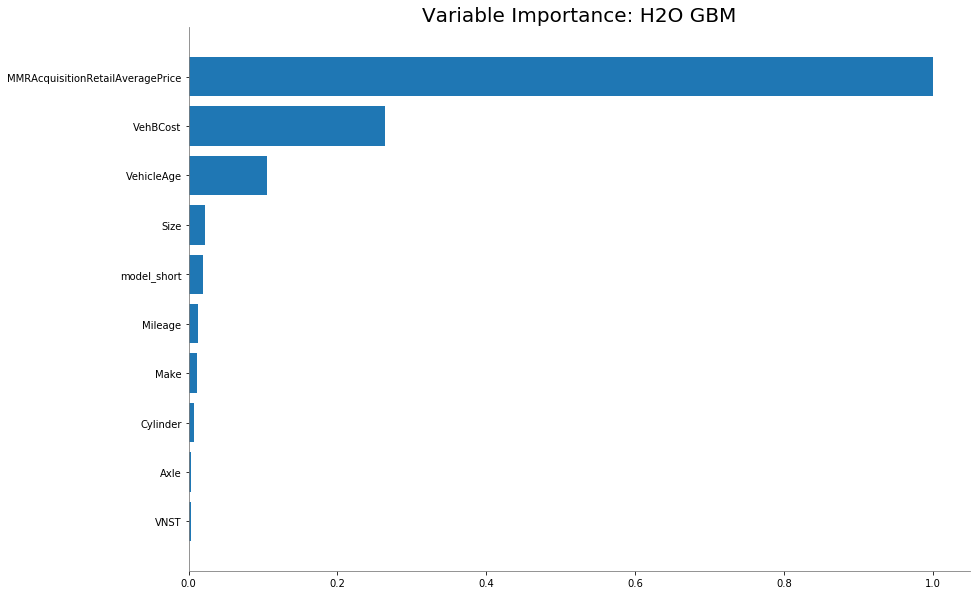

In [29]:
gb_model.varimp_plot()



In [73]:
predict_m1=pred_model1.as_data_frame()  

In [146]:
predict_m1.describe()

,predict
count,10916.000000
mean,-0.009480
std,0.972752
min,-2.938790
25%,-0.736335
50%,-0.018615
75%,0.648452
max,9.103945



### **Model 3:**  DistributedRandomForest (DRF) 

The speed and scale of AutoML feature we witnessed during binary classification phase, we decided to pivot in our model building approach to get maximum benefit from our constrained computing resources, efficiency in training and optimum results in our final model for DRF regression phase. 

For the AutoML regression leaderboard session, the goal was to predict the Automobile Auction’s Average Acquisition price (MMRAcquisitionAuctionAveragePrice) within the dataset we used for binary classification.  we employed H2O AutoML interface which is designed to have as few parameters as possible while limiting the number of total models (max_models) that are trained with the goal of finding the “best” model with a desired stopping metric (RMSE) and algorithm preference (DRF). 

H2O AutoML helped identify the best performing DRF regression model with RMSE as a predefined stopping matrix for response variable (MMRAcquisitionAuctionAveragePrice) to narrow down the best DRF model where H2O DRF libraries help determine the optimal values to be used for the hyperparameters of the lead model. From H2O supervised learning model metrics, we considered Root Mean Squared Error (RMSE) for optimizing our final DRF model. It helps evaluate predictive accuracy of the target variable which is useful of understanding if the size of the error is of any concern or not. We also wanted a metric to be sensitive to outlier and therefore we opted with RMSE which help does that. We choose the best of two AutoML model resulting a 0.160431 RMSE with 50 trees. We proceed with leader H2O AutoML model with a hope to improve prediction error that resulted with a 0.168221 RMSE. 

Model Output:  DRF – training set.

* MSE: 0.03167895819395779 
* RMSE: 0.17798583706002505
* MAE: 0.10403058484855394 
* RMSLE: NaN 
* Mean Residual Deviance: 0.03167895819395779

Model Output:  DRF – validation set. 

* MSE: 0.11758712046760021 
* RMSE: 0.3429097847358693
* MAE: 0.29801325477263746 
* RMSLE: 0.2915958225237462 
* Mean Residual Deviance: 0.11758712046760021

Model Output:  DRF – cross-validation set.

* MSE: 0.0282984304313963 
* RMSE: 0.16822137328947323
* MAE: 0 0.09736480656323976 
* RMSLE: NaN
* Mean Residual Deviance: 0.0282984304313963



In [38]:
from h2o.estimators.random_forest import H2ORandomForestEstimator
# ### Distributed Random Forest #Task2
folds = 10
drf_MMRA_A_A_Price_Final = H2ORandomForestEstimator(
    model_id="drf_MMRA_A_A_Price_Final",
    ntrees=50,
    max_depth=20,
    stopping_rounds=5,
    stopping_tolerance=0.01,
    score_each_iteration=True,
    seed=3000000,
    nfolds = folds,
    keep_cross_validation_predictions = True,
    binomial_double_trees = True,
    stopping_metric = "RMSE",
    balance_classes = True)


drf_MMRA_A_A_Price_Final.train(x=x, y=y, training_frame=train, validation_frame = valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [39]:
# retrieve the model performance
perf = drf_MMRA_A_A_Price_Final.model_performance(valid)
perf


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 0.11758712046760021
RMSE: 0.3429097847358693
MAE: 0.29801325477263746
RMSLE: 0.2915958225237462
Mean Residual Deviance: 0.11758712046760021


In [48]:
drf_MMRA_A_A_Price_Final.model_performance(xval = True)


ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.0282984304313963
RMSE: 0.16822137328947323
MAE: 0.09736480656323976
RMSLE: NaN
Mean Residual Deviance: 0.0282984304313963


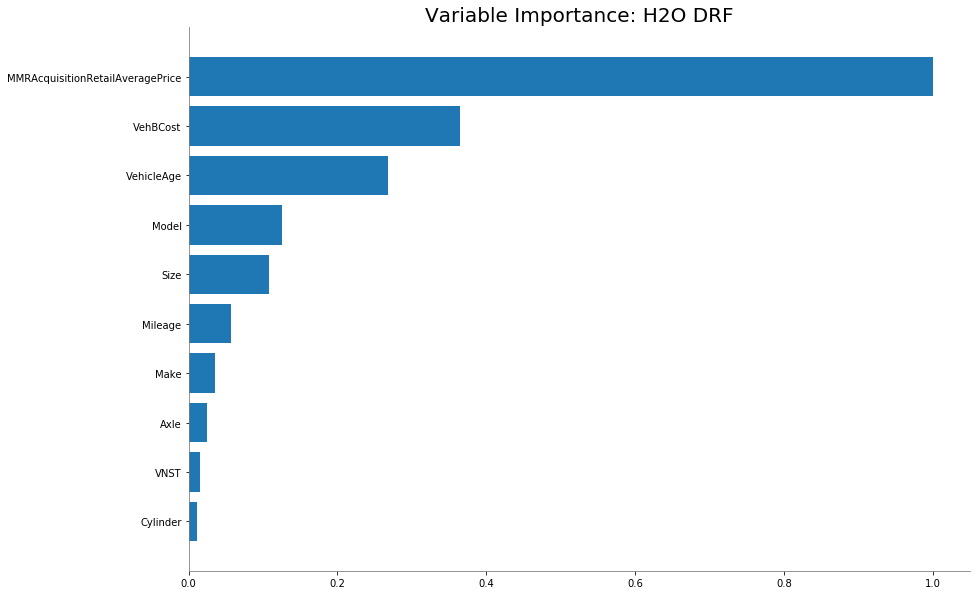

In [50]:
drf_MMRA_A_A_Price_Final.varimp_plot()

In [51]:
drf_MMRA_A_A_Price_Final

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  drf_MMRA_A_A_Price_Final


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,22.0,22.0,9517752.0,20.0,20.0,20.0,19222.0,23243.0,21075.092




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.03167895819395779
RMSE: 0.17798583706002505
MAE: 0.10403058484855394
RMSLE: NaN
Mean Residual Deviance: 0.03167895819395779

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.11758712046760021
RMSE: 0.3429097847358693
MAE: 0.29801325477263746
RMSLE: 0.2915958225237462
Mean Residual Deviance: 0.11758712046760021

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.0282984304313963
RMSE: 0.16822137328947323
MAE: 0.09736480656323976
RMSLE: NaN
Mean Residual Deviance: 0.0282984304313963

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,0.097371094,0.0021445174,0.09487803,0.097697616,0.100921184,0.09600016,0.098482065,0.09696273,0.09419199,0.09920104,0.09935068,0.096025445
1,mean_residual_deviance,0.028301818,0.0024500145,0.026454499,0.026841028,0.030078894,0.027143013,0.026010338,0.028697392,0.025222642,0.028539939,0.031163221,0.032867208
2,mse,0.028301818,0.0024500145,0.026454499,0.026841028,0.030078894,0.027143013,0.026010338,0.028697392,0.025222642,0.028539939,0.031163221,0.032867208
3,r2,0.9717024,0.002117586,0.9731768,0.9726457,0.97082466,0.97217983,0.97332835,0.97108066,0.97529346,0.9714549,0.96868104,0.9683588
4,residual_deviance,0.028301818,0.0024500145,0.026454499,0.026841028,0.030078894,0.027143013,0.026010338,0.028697392,0.025222642,0.028539939,0.031163221,0.032867208
5,rmse,0.16809233,0.0072100363,0.1626484,0.16383232,0.17343268,0.16475137,0.1612772,0.16940305,0.15881638,0.16893768,0.17653108,0.18129316
6,rmsle,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2019-10-27 14:11:41,2 min 56.477 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-10-27 14:11:41,2 min 57.265 sec,1.0,0.273053,0.147791,0.074558,0.426906,0.367976,0.182248
2,,2019-10-27 14:11:42,2 min 58.041 sec,2.0,0.265980,0.142400,0.070745,0.360739,0.306031,0.130132
3,,2019-10-27 14:11:43,2 min 58.709 sec,3.0,0.259306,0.139109,0.067239,0.363447,0.310719,0.132094
4,,2019-10-27 14:11:43,2 min 59.407 sec,4.0,0.246536,0.135156,0.060780,0.364049,0.310830,0.132532
5,,2019-10-27 14:11:44,3 min 0.250 sec,5.0,0.240985,0.132622,0.058074,0.346326,0.289818,0.119942
6,,2019-10-27 14:11:45,3 min 1.050 sec,6.0,0.231332,0.128425,0.053515,0.346633,0.290808,0.120155
7,,2019-10-27 14:11:46,3 min 1.808 sec,7.0,0.223917,0.125317,0.050139,0.351966,0.301363,0.123880
8,,2019-10-27 14:11:47,3 min 2.545 sec,8.0,0.215713,0.122427,0.046532,0.344621,0.290128,0.118763
9,,2019-10-27 14:11:47,3 min 3.256 sec,9.0,0.209419,0.119620,0.043856,0.347395,0.295176,0.120684



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,MMRAcquisitionRetailAveragePrice,402989.312500,1.000000,0.489006
1,VehBCost,146816.812500,0.364319,0.178154
2,VehicleAge,108113.226562,0.268278,0.131190
3,Model,50520.000000,0.125363,0.061303
4,Size,43305.894531,0.107462,0.052549
5,Mileage,22772.785156,0.056510,0.027634
6,Make,14446.900391,0.035849,0.017531
7,Axle,10018.476562,0.024860,0.012157
8,VNST,6071.148926,0.015065,0.007367
9,Cylinder,4577.852051,0.011360,0.005555



See the whole table with table.as_data_frame()


In [52]:
## Final Prediction for Model 2
final_drf_predictions = drf_MMRA_A_A_Price_Final.predict(test)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [53]:
final_drf_predictions.head()

predict
0.281984
-0.195952
-0.289382
-0.11376
-0.20504
-0.102207
-0.16848
0.238103
0.00969346
-0.071046


In [54]:
drf_MMRA_A_A_Price_Final.model_performance()


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.03167895819395779
RMSE: 0.17798583706002505
MAE: 0.10403058484855394
RMSLE: NaN
Mean Residual Deviance: 0.03167895819395779


In [55]:
drf_MMRA_A_A_Price_Final.r2()

0.9683204736576184

## 3.4 Comparing Model Results

### 3.4.1 Classification Models

Summaries of each final model, along with the confusion matrices for each final model, are provided below. Since we have simplified our model search, based on business objectives, to target precision as the predominant model ranking metric, we can easily see that XGBoost outperforms both of the ADABoost and DRF models. XGBoost also has the added benefit of outperforming  the other models for Recall, Accuracy, and F1. We say this, however, knowing that ADABoost and DRF were both optimized for Precision specifically, so this comparison is only superficial and specific to the hyperparameters chosen for the model run.

Precision was chosen since we wanted to make sure that a car that was classified as a bad buy, was actually a bad buy. This over riding objective subjugates Recall, such that having our model miss some bad buys is an acceptable outcome. For future models if the business wanted to attempt eliminate bad buys from any purchase, and incur the potential for marking some good bays as bad buys, a different metric should be chosen. In this case, we would recommend optimizing ROC-AUC, or optimizing for Recall alone.

The confusion matrices below are provided to show the potential outcomes for each model prediction profile. For the reader, this should visually display the proportions of predictions classified as positive and negative, along with the false positive and false negative outcomes. This can be used to guide further refinement against business goals, or to potentially guide changes in methodology moving forward. 

| **Classification Model Summary** |
|----------------------------------|

| Metric   | XGBoost    | ADABoost | Discrete Random Forest            |
|-----------|-------------|------------------------|-------------|
| Precision | 0.950657895 | 0.847222222            | 0.73934   |
| Recall    | 0.161002786 | 0.033983287            | 0.00001    |
| Accuracy  | 0.895800507 | 0.880454888            | 0.26923    |
| ROC-AUC   | 0.579915547 | 0.516562023            | 0.72995 |
| F1        | 0.275369223 | 0.065345474            | 0.10626     |
| F2        | 0.193078568 | 0.042057363            | 0.47057     |



### 3.4.1.1 XGBOOST Confusion Matrix

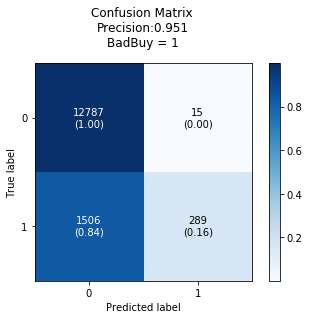

In [89]:
#XGBOOST Confusion Matrix

import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
cm = [[12787, 15],
       [1506, 289]]
binary = np.array(cm)

fig, ax = plot_confusion_matrix(conf_mat=binary,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

plt.title('Confusion Matrix \nPrecision:{0:.3f}'.format(0.9506578947368421) + '\nBadBuy = 1')
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

### 3.4.1.2 ADABoost Confusion Matrix

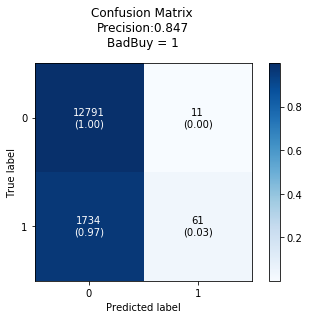

In [85]:
#ADABoost Confusion Matrix

import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
cm = confusion

binary = np.array(cm)
fig, ax = plot_confusion_matrix(conf_mat=binary,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

plt.title('Confusion Matrix \nPrecision:{0:.3f}'.format(prec) + '\nBadBuy = 1')
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

### 3.4.1.3 H2O DRF Confusion Matrix

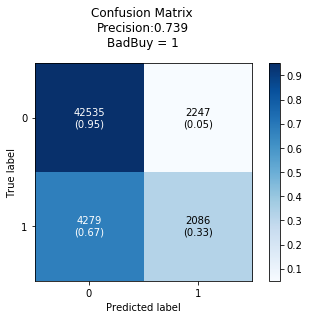

In [72]:
#H2O DRF Confusion Matrix

import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
cm = [[42535,    2247],
       [ 4279,   2086]]

binary = np.array(cm)
fig, ax = plot_confusion_matrix(conf_mat=binary,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

plt.title('Confusion Matrix \nPrecision:{0:.3f}'.format(0.73934) + '\nBadBuy = 1')
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()


### 3.4.1 Regression Models


Summaries of each final model, along with the Variable importance plot or top feature contributions for each model are provided below.  Since we have simplified our model search, based on business objectives, to target RMSE as the predominant model ranking metric, we can easily see that GLM outperforms both of the GBM and DRF models. GLM also has the added benefit of providing faster and more stable computations that can provide to be helpful during time constraints. While the GBM model is not without merit, it is prone to overfitting at times since the models are run sequentially.  The high R2 of 0.963 is evidence of model overfitting.

The RMSE metric evaluates how well a model can predict a continuous value. The RMSE units are the same as the predicted target, which is useful for understanding if the size of the error is of concern or not. The smaller the RMSE, the better the model’s performance. Since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors. Based on this criteria, we can summarize that while we have one identified superior model,  all three regression models in general provide adequate prediction estimates given that all three models show low RMSE and sufficient R2 values (at the risk of overfitted).

Summaries of each final model are provided below, in addition to variable importance and feature contributions for the top performing model. Since we have simplified our model search, based on business objectives, to target RMSE as the predominant model ranking metric, we can easily see that GLM outperforms both of the GBM and DRF models. GLM also has the added benefit of providing faster and more stable computations that can provide to be helpful during time constraints. While the GBM model is not without merit, it is prone to overfitting at times since the models are run sequentially.  The high R2 of 0.963 is evidence of model overfitting.

|**Performance Metric**    | Model 1| Model 2| Model 3|
|----------|--------|--------|--------|
|**Model Type:**|  GLM   |   GBM  |   DRF  |
|**RMSE:**|0.021152|0.197661|0.168221|
|**R2:**|0.906000|0.963171|0.968320|
| **MSE:**|0.000447|0.039069|0.028298|
|**MAE:**|0.016625|0.139208|0.097364|




### 3.5 Comparing Advantages & Disadvantages


### 3.5.1 Classification Models

***Advantages / Disadvantages - XGBoost***

*Advantages*
* Regularization - XGBoost has built in Lasso and Ridge Regression. This helps prevent overfitting.
* Training Performance - XGBoost has built in parallel processing that can leverage multiple cores.
* Tree Pruning and Cross Validation - Effective tree pruning and stopping, as well as built in cross validation support.

*Disadvantages*
* XGBoost can be slow with a large number of variables.
* It can create complex models.

***Advantages / Disadvantages - ADABoost***

*Advantages*
* Can achieve good results with less changes of parameters.

*Disadvantages*
* Can be sensitive to noise and outliers.
* ADABoost can be susceptible to overfitting problems.

***Advantages / Disadvantages - DRF***

*Advantages*
* Is less prone to overfitting, and has less variance, than decision trees.
* Has high accuracy.
* No preconditions on scaling data.

*Disadvantages*
* Complexity - They are more time consuming to construct and train than decision trees.

**By our estimation the XGBoost model is the best model out of the three. It provides the best precision for the classification tasks, and the best overall flexibility for preventing overfitting.**

### 3.5.1 Regression Models

**Advantages / Disadvantages - DRF**

Key advantages of DRF is that it works well with large scale of data and is highly flexible. It can handle categorical and numerical features very well.  However, they are very complex and require high computing resources. The prediction process using DRF is time consuming compare to other algorithms due to constructing decision tree which makes them very difficult to interpret.

**Advantages / Disadvantages - GLM**

*Advantages* 
* Can achieve stable results in a short amount of time
* The least expensive regression model
* Overfitting Avoidance

*Disadvantages*
* Simplistic in nature-may not capture all true relationships

**Advantages / Disadvantages - GBM**

*Advantages*
* Very flexible in that you can optimize on different loss functions. 
* Imputation is not needed since it handles missing data automatically.

*Disadvantages*
* It continues to try to improve by minimizing errors; it can easily overfit.  Stopping parameters must be tuned.  
* High computation costs.  Requires over 1000 trees.

### 3.6 Feature Importance

### 3.6.1 Classification Models

As shown below, f0, f4, f8, and f5 all appear as the top weighted variables for the XGBoost model. In this case this aligns to the Vehicle Year, Vehicle Odometer, the Vehicle acquisition cost, and state. Given these results this inherently makes sense since many of the bad buys are associated with specific locales, age and overall condition. One hypothesis is that a certain proportion of bad buys are a result of individuals making repeated bad decisions about value. If we were able to correlate the purchases to specific individuals, we may see this specifically and be able to predict who can and cant be trusted to purchase cars. 

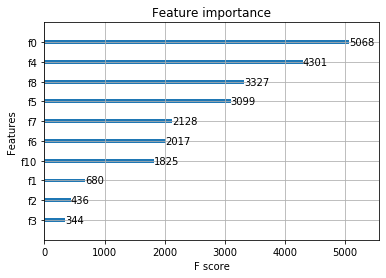

In [60]:
# plot feature importance
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(clf, max_num_features=10) # top 10 most important features
pyplot.show()


### 3.6.1 Regression Models

Based on the GLM Model, please see below for interpretation of regression coefficient for each variable.

* There is significant evidence that used Cars that have axle types equal to 4WD are associated with a 0.0087 increase in the  predicted MMR Acquisition Avg. Price Estimate, holding all other variables constant. A 95% confidence interval is (0.0082, 0.0093).

* There is significant evidence that used Cars that have axle types equal to AWD are associated with a 0.0068 increase in the  predicted MMR Acquisition Avg. Price Estimate, holding all other variables constant. A 95% confidence interval is (0.0057, 0.0078).

* There is significant evidence that used Cars that have axle types equal to FWD are associated with a 0.0036 decrease in the  predicted MMR Acquisition Average Price estimate, holding all other variables constant. A 95% confidence interval is (-0.0042, -0.0030).

* There is significant evidence that used Cars with unknown axle types are associated with a 0.0037 decrease in the  predicted MMR Acquisition Average Price estimate, holding all other variables constant. A 95% confidence interval is (-0.0045, -0.0029).

* There is significant evidence that used cars with black exterior are associated with a 0.0015 increase in the  predicted MMR Acquisition Avg. Price Estimate, holding all other variables constant. A 95% confidence interval is (0.0008, 0.0022).

* There is significant evidence that used cars with unknown color exteriors are associated with a 0.0064 increase in the  predicted MMR Acquisition Avg. Price Estimate, holding all other variables constant. A 95% confidence interval is (0.0036, 0.0091).

* There is significant evidence that used cars with other exterior colors are associated with a 0.0115 increase in the  predicted MMR Acquisition Avg. Price Estimate, holding all other variables constant. A 95% confidence interval is (0.0098, 0.0133).

* There is significant evidence that used cars with V4 cylinders are associated with a 0.0042 increase in the  predicted MMR Acquisition Avg. Price Estimate, holding all other variables constant. A 95% confidence interval is (0.0039, 0.0045).

* There is significant evidence that used cars with V6 cylinders are associated with a 0.0102 increase in the  predicted MMR Acquisition Avg. Price Estimate, holding all other variables constant. A 95% confidence interval is (0.0099, 0.0104).

* There is significant evidence that used cars with V8 cylinders are associated with a 0.0096 increase in the  predicted MMR Acquisition Avg. Price Estimate, holding all other variables constant. A 95% confidence interval is (0.0091, 0.0102).

* There is significant evidence that used cars available to be sold online are associated with a 0.0106 decrease in the  predicted MMR Acquisition Average Price estimate, holding all other variables constant. A 95% confidence interval is (-0.0112, -0.0100).

* There is significant evidence that used cars with high mileage are associated with a 0.0025 decrease in the  predicted MMR Acquisition Average Price estimate, holding all other variables constant. A 95% confidence interval is (-0.0028, -0.0021).

* There is significant evidence that used cars with low mileage are associated with a 0.0065 increase in the  predicted MMR Acquisition Avg. Price Estimate, holding all other variables constant. A 95% confidence interval is (0.0061, 0.0070).

* There is significant evidence that for every 1USD increase inMMR Acquisition Retail Price; The MMR Acquisition Average Price Estimate will increase by 0.5391, holding all other variables constant. A 95% confidence interval is (0.5371, 0.5411).

* There is significant evidence that used cars that are the size of Crossovers are associated with a 0.0138 increase in the  predicted MMR Acquisition Avg. Price Estimate, holding all other variables constant. A 95% confidence interval is (0.0127, 0.0149).

* There is significant evidence that used cars that are the size of large vehicles are associated with a 0.0038 increase in the  predicted MMR Acquisition Avg. Price Estimate, holding all other variables constant. A 95% confidence interval is (0.0033, 0.0044).

* There is significant evidence that used cars that are the size of large SUVs are associated with a 0.0286 increase in the  predicted MMR Acquisition Avg. Price Estimate, holding all other variables constant. A 95% confidence interval is (0.0275, 0.0298).

* There is significant evidence that used cars that are the size of large trucks are associated with a 0.0169 increase in the  predicted MMR Acquisition Avg. Price Estimate, holding all other variables constant. A 95% confidence interval is (0.0160, 0.0178).

* There is significant evidence that used cars that are the size of medium vehicles are associated with a 0.0010 increase in the  predicted MMR Acquisition Avg. Price Estimate, holding all other variables constant. A 95% confidence interval is (0.0006, 0.0013).

* There is significant evidence that used cars that are the size of medium SUVs are associated with a 0.0105 increase in the  predicted MMR Acquisition Avg. Price Estimate, holding all other variables constant. A 95% confidence interval is (0.0096, 0.0114).

* There is significant evidence that used cars that are the size of small SUVs are associated with a 0.0086 increase in the  predicted MMR Acquisition Avg. Price Estimate, holding all other variables constant. A 95% confidence interval is (0.0076, 0.0097).

* There is significant evidence that used cars that are the size of small trucks are associated with a 0.0042 increase in the  predicted MMR Acquisition Avg. Price Estimate, holding all other variables constant. A 95% confidence interval is (0.0030, 0.0055).

* There is significant evidence that used cars that are the size of specialty vehicles are associated with a 0.0182 increase in the  predicted MMR Acquisition Avg. Price Estimate, holding all other variables constant. A 95% confidence interval is (0.0175, 0.0190).

* There is significant evidence that used cars that are the size of sports vehicles are associated with a 0.0163 increase in the  predicted MMR Acquisition Avg. Price Estimate, holding all other variables constant. A 95% confidence interval is (0.0153, 0.0173).

* There is significant evidence that used cars that are unknown in size are associated with a 0.0271 decrease in the  predicted MMR Acquisition Average Price estimate, holding all other variables constant. A 95% confidence interval is (-0.0365, -0.0176).

* There is significant evidence that for every 1USD increase in vehicle cost; the MMR Acquisition Average Price mean  estimate will decrease by  0.2642, holding all other variables constant. A 95% confidence interval is (0.2596, 0.2689).

* There is significant evidence that for every one year increase in vehicle age; the MMR Acquisition Average Price Estimate will decrease by 0.0121, holding all other variables constant. A 95% confidence interval is (-0.0122, -0.0120).

* There is significant evidence that for every one mile increase in the vehicle odometer ; the MMR Acquisition Average Price Estimate will increase by 0.01406, holding all other variables constant. A 95% confidence interval is (0.0129, 0.0151).

* There is significant evidence that for every 1USD increase in warranty cost; the MMR Acquisition Average Price Estimate will increase by 0.01031, holding all other variables constant. A 95% confidence interval is (0.0086, 0.0119).

* There is significant evidence that used cars with cover wheel types are associated with a 0.0050 decrease in the  predicted MMR Acquisition Average Price estimate, holding all other variables constant. A 95% confidence interval is (-0.0052, -0.0047).

* There is significant evidence that used cars with cover special types are associated with a 0.0026 decrease in the  predicted MMR Acquisition Average Price estimate, holding all other variables constant. A 95% confidence interval is (-0.0036, -0.0017).

* There is significant evidence that used cars with cover unknown types are associated with a 0.0016 decrease in the  predicted MMR Acquisition Average Price estimate, holding all other variables constant. A 95% confidence interval is (-0.0020, -0.0011).



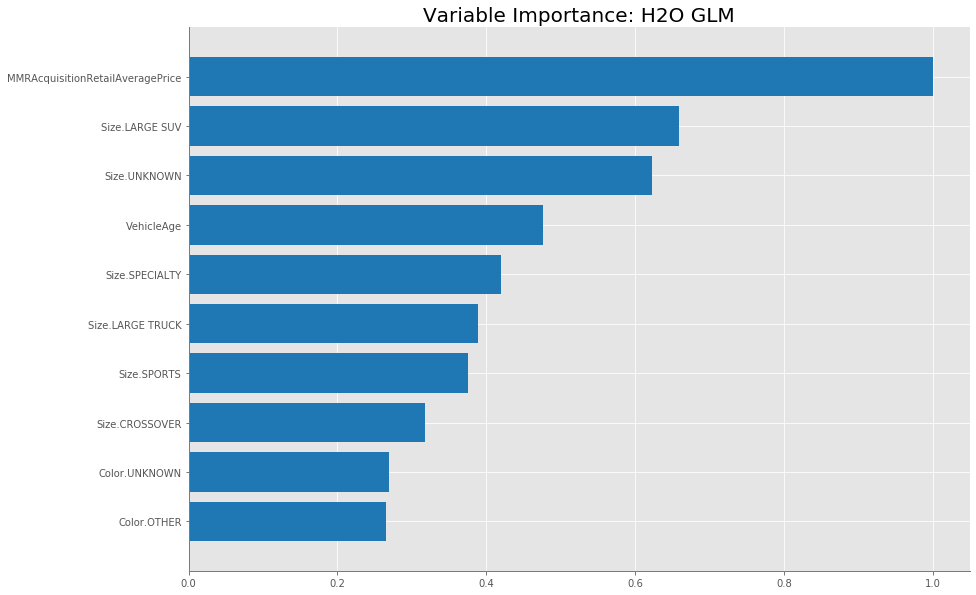

In [45]:
glm_price.varimp_plot()

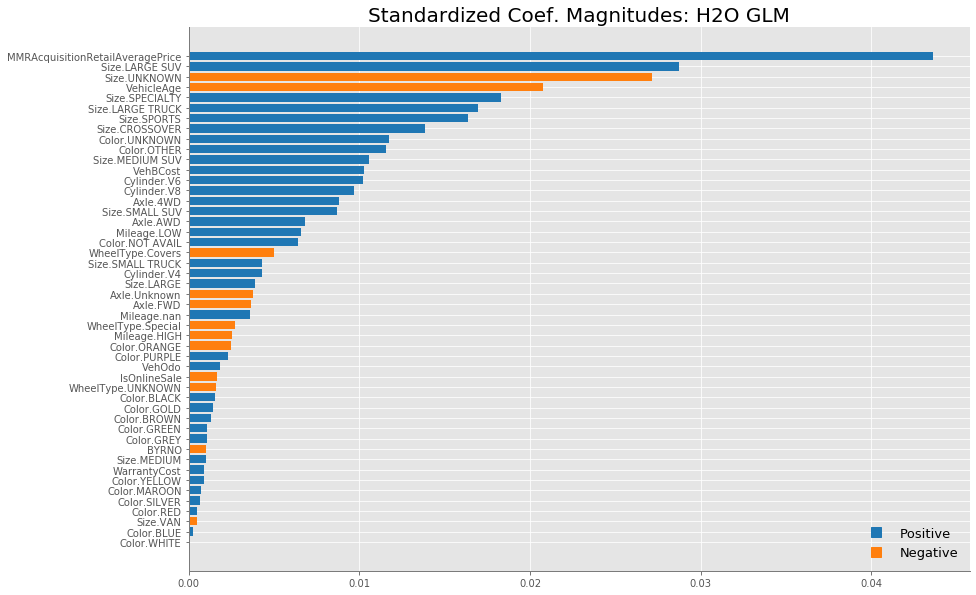

In [44]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(8,16)
plt.rcParams["xtick.labelsize"]= 10
plt.rcParams["ytick.labelsize"]= 10
glm_price.std_coef_plot()


## 4.2 Performing Grid Searches


### 4.2.1 Classification Tasks
In an attempt to improve our models, we performed numerous grid searches across ADAGradientBoosting and XGBoost. We also added a new model for Bagging, with a default classifier or Decision Tree. We performed a gridsearch to optimized this model, which performed better for classification (Precision and Recall). This is shown in the performance metrics table. 

* ROC-AUC: 0.615
* Accuracy: 0.902
* Precision: 0.832

### 4.2.1.1 Bagging Grid Search


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import matthews_corrcoef
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import numpy as np
import xgboost as xgb


from sklearn.impute import SimpleImputer


#create a max/min scaler
kick_scaled = kick_data

imputer = SimpleImputer(strategy="most_frequent")
print(imp.fit_transform(kick_scaled))   



#one hot encoding
tmp = pd.concat([pd.get_dummies(kick_scaled[col],prefix=col) for col in categorical_features], axis=1)
one_hot = pd.concat((kick_scaled, tmp), axis=1)

#remove the categoricals
for col in categorical_features:
    del one_hot[col]
    
# we want to predict the X and y data as follows:
if 'IsBadBuy' in one_hot:
    y = one_hot['IsBadBuy'].values # get the labels we want
    del one_hot['IsBadBuy'] # get rid of the class label
    X = one_hot.values # use everything else to predict!
    
num_cv_iterations = 10
num_instances = len(y)
cv_object = StratifiedShuffleSplit(n_splits=num_cv_iterations, test_size  = 0.2)
                         
print(cv_object)

#from sklearn.preprocessing import Imputer
#imputer = Imputer()
#transformed_X = imputer.fit_transform(X)

for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables for readability
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)

StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.2,
            train_size=None)


In [18]:
from sklearn.metrics import fbeta_score, make_scorer

scoring = {'AUC': 'roc_auc', 'F0.5': make_scorer(fbeta_score, beta=0.5)}

param_grid = {'n_estimators':[2000],'max_samples':[1000], 
              'max_features':[1000], 'bootstrap':[True],
              'bootstrap_features':[True]}
grid = GridSearchCV(BaggingClassifier(), param_grid, scoring=scoring, refit='AUC', return_train_score=True, verbose=2, n_jobs = -1,cv=5)
grid.fit(X_train,y_train)
results = grid.cv_results_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 178.4min remaining: 118.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 178.6min finished


In [19]:
grid.best_params_

{'bootstrap': True,
 'bootstrap_features': True,
 'max_features': 1000,
 'max_samples': 1000,
 'n_estimators': 2000}

In [20]:
predic = grid.predict(X_test)

In [21]:
print(classification_report(y_test,predic))
print(confusion_matrix(y_test, predic))
print(roc_auc_score(y_test, predic))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     12829
           1       0.96      0.02      0.05      1768

    accuracy                           0.88     14597
   macro avg       0.92      0.51      0.49     14597
weighted avg       0.89      0.88      0.83     14597

[[12827     2]
 [ 1725    43]]


In [33]:
from sklearn.metrics import fbeta_score, make_scorer

scoring = {'AUC': 'roc_auc', 'F0.5': make_scorer(fbeta_score, beta=0.5)}

#param_grid = {'n_estimators':[2000],'max_samples':[1000], 
#              'max_features':[1000], 'bootstrap':[True],
#              'bootstrap_features':[True]}
#param_grid = {'n_estimators': [40, 42], 
#               'base_estimator__max_leaf_nodes':[10, 15], 
#               'base_estimator__max_depth':[4, 5, 6]}
#param_grid = {'n_estimators': [500, 1000], 
#              'base_estimator__max_leaf_nodes':[25, 50, 100], 
#              'base_estimator__max_depth':[5,10,50],
#              'base_estimator__min_samples_split':[2,10,25,50],
#              'base_estimator__class_weight':['balanced']}
param_grid = {'n_estimators': [42], 
               'base_estimator__max_leaf_nodes':[15], 
               'base_estimator__max_depth':[5]}
dt = DecisionTreeClassifier()
bc = BaggingClassifier(base_estimator=dt, oob_score=True, random_state=1)
grid = GridSearchCV(estimator=bc, param_grid=param_grid, 
                    scoring=scoring, refit='AUC', 
                    return_train_score=True, 
                    verbose=2, n_jobs = -1,cv=3)
grid.fit(X_train,y_train)
results = grid.cv_results_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  8.5min finished


In [34]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__max_depth,param_base_estimator__max_leaf_nodes,param_n_estimators,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_train_AUC,split1_train_AUC,split2_train_AUC,mean_train_AUC,std_train_AUC,split0_test_F0.5,split1_test_F0.5,split2_test_F0.5,mean_test_F0.5,std_test_F0.5,rank_test_F0.5,split0_train_F0.5,split1_train_F0.5,split2_train_F0.5,mean_train_F0.5,std_train_F0.5
0,207.654604,0.054489,63.347853,0.633188,5,15,42,"{'base_estimator__max_depth': 5, 'base_estimat...",0.742573,0.752185,0.741014,0.745257,0.00494,1,0.751716,0.745305,0.751228,0.749416,0.002914,0.547423,0.554279,0.550406,0.550703,0.002807,1,0.555556,0.556492,0.557047,0.556365,0.000616


In [35]:
grid.best_params_

{'base_estimator__max_depth': 5,
 'base_estimator__max_leaf_nodes': 15,
 'n_estimators': 42}

In [36]:
predic = grid.predict(X_test)
print(classification_report(y_test,predic))
print(confusion_matrix(y_test, predic))

              precision    recall  f1-score   support

           0       0.90      0.99      0.95     12829
           1       0.83      0.24      0.37      1768

    accuracy                           0.90     14597
   macro avg       0.87      0.61      0.66     14597
weighted avg       0.90      0.90      0.88     14597

[[12745    84]
 [ 1351   417]]


In [37]:
print(roc_auc_score(y_test, predic))


0.6146560315306561


In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
pred = predic
def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, pos_label=1)

def f_half_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=0.5, pos_label=1)

# Calculate our Metric - accuracy
accuracy = accuracy_score(y_test, pred>0.5)
roc_auc = roc_auc_score(y_test, pred>0.5)
prec = precision_score(y_test, pred)
confusion = confusion_matrix(y_test, pred)

print('Best ROC-AUC:' + str(roc_auc))
print('Best Accuracy:' + str(accuracy))
print('Best Precision:' + str(prec))
print('Best Recall:', recall_score(y_test, pred))
print('F1 Score:', f1_score(np.array(y_test), np.array(pred)))
print('F2 Score:', f2_score(np.array(y_test), np.array(pred)))
print('F0.5 Score:', f_half_score(np.array(y_test), np.array(pred)))
print('MCC:', matthews_corrcoef(np.array(y_test), np.array(pred)))
confusion

Best ROC-AUC:0.6146560315306561
Best Accuracy:0.9016921285195588
Best Precision:0.8323353293413174
Best Recall: 0.23585972850678733
F1 Score: 0.3675628029969149
F2 Score: 0.2753202165588274
F0.5 Score: 0.5527571580063626
MCC: 0.4109581768287949


array([[12745,    84],
       [ 1351,   417]])

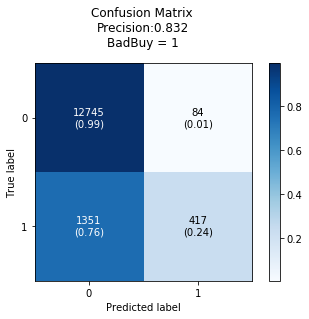

In [40]:
#Confusion Matrix
# Transform to df for easier plotting
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
cm = confusion

binary = np.array(cm)
fig, ax = plot_confusion_matrix(conf_mat=binary,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

plt.title('Confusion Matrix \nPrecision:{0:.3f}'.format(prec) + '\nBadBuy = 1')
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

# Modeling Appendix

## Classifier Search

In [70]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#Train with found / optimized parameters
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
import xgboost as xgb
from sklearn.metrics import matthews_corrcoef

def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, pos_label=1)

def f_half_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=0.5, pos_label=1)

classifiers = [
    KNeighborsClassifier(3),
    #SVC(kernel="rbf", C=0.025, probability=True),
    #NuSVC(probability=True),
    xgb.XGBClassifier(),
    HistGradientBoostingClassifier(),
    BaggingClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

#eval_set  = [( X_train, y_train), ( X_test, y_test)]
    

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Precision","Recall", "Log Loss", "ROC-AUC", "F1", "F2", "F0.5","mcc" ]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    name = clf.__class__.__name__
    print('****Results****')
    print("="*30)
    print(name)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    # Calculate our Metrics
    accuracy = accuracy_score(y_test, pred>0.5)
    roc_auc = roc_auc_score(y_test, pred>0.5)
    prec = precision_score(y_test, pred)
    confusion = confusion_matrix(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(np.array(y_test), np.array(pred))
    f2 = f2_score(np.array(y_test), np.array(pred))
    f_half = f_half_score(np.array(y_test), np.array(pred))
    mcc = matthews_corrcoef(np.array(y_test), np.array(pred))

    print('ROC-AUC:' + str(roc_auc))
    print('Accuracy:' + str(accuracy))
    print('Precision:' + str(prec))
    print('Recall:', str(recall))
    print('F1 Score:', str(f1))
    print('F2 Score:', str(f2))
    print('F0.5 Score:', str(f_half))
    print('Matthews Correlation Coefficient:', str(mcc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, accuracy*100, prec*100, recall*100, ll, roc_auc, f1, f1, f_half, mcc ]], columns=log_cols)
    log = log.append(log_entry)
    
    matrix = pd.DataFrame(confusion,
        columns=['Predicted 0', 'Predicted 1'],
        index=['Actual 0', 'Actual 1'],
        )
    print('*' * 15 + '*' * 15)
    print(name)
    print(matrix)
    print('*' * 15 + '*' * 15)
    
print("="*30)

****Results****
KNeighborsClassifier
ROC-AUC:0.5309913275215093
Accuracy:0.8566143728163321
Precision:0.27217125382262997
Recall: 0.09916434540389972
F1 Score: 0.1453654552878726
F2 Score: 0.11360735256573909
F0.5 Score: 0.2017683065064611
Matthews Correlation Coefficient: 0.09839529348930784
Log Loss: 2.732085458449855
******************************
KNeighborsClassifier
          Predicted 0  Predicted 1
Actual 0        12326          476
Actual 1         1617          178
******************************
****Results****
XGBClassifier
ROC-AUC:0.6158118356332728
Accuracy:0.9012125779269713
Precision:0.8537074148296593
Recall: 0.2373259052924791
F1 Score: 0.3714036617262423
F2 Score: 0.27737986717020446
F0.5 Score: 0.5618570298074387
Matthews Correlation Coefficient: 0.4186248962531616
Log Loss: 0.2984146956582026
******************************
XGBClassifier
          Predicted 0  Predicted 1
Actual 0        12729           73
Actual 1         1369          426
***************************

/Users/chandlervaughn/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ROC-AUC:0.5939801580445953
Accuracy:0.8914845516201959
Precision:0.7089108910891089
Recall: 0.19944289693593314
F1 Score: 0.3113043478260869
F2 Score: 0.2329212752114509
F0.5 Score: 0.4692005242463958
Matthews Correlation Coefficient: 0.33775773085501387
Log Loss: 1.1535585199806224
******************************
RandomForestClassifier
          Predicted 0  Predicted 1
Actual 0        12655          147
Actual 1         1437          358
******************************
****Results****
AdaBoostClassifier
ROC-AUC:0.6116563872549509
Accuracy:0.895183941905871
Precision:0.7280550774526678
Recall: 0.23565459610027856
F1 Score: 0.3560606060606061
F2 Score: 0.27251642829532274
F0.5 Score: 0.5134741442097597
Matthews Correlation Coefficient: 0.37513241651361806
Log Loss: 0.6733125324840701
******************************
AdaBoostClassifier
          Predicted 0  Predicted 1
Actual 0        12644          158
Actual 1         1372          423
******************************
****Results****
Gradi

/Users/chandlervaughn/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


ROC-AUC:0.6281992193942537
Accuracy:0.8905939576625334
Precision:0.6225247524752475
Recall: 0.28022284122562674
F1 Score: 0.38647714175950826
F2 Score: 0.3148472709063596
F0.5 Score: 0.5002983887010146
Matthews Correlation Coefficient: 0.3682259981911094
Log Loss: 0.36619508198948886
******************************
LinearDiscriminantAnalysis
          Predicted 0  Predicted 1
Actual 0        12497          305
Actual 1         1292          503
******************************
****Results****
QuadraticDiscriminantAnalysis


/Users/chandlervaughn/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


ROC-AUC:0.4963649699581237
Accuracy:0.15818318832636843
Precision:0.12214620093626215
Recall: 0.9448467966573816
F1 Score: 0.21632653061224488
F2 Score: 0.40256349394730595
F0.5 Score: 0.1479026772477544
Matthews Correlation Coefficient: -0.011083991884979627
Log Loss: 29.07532262387219
******************************
QuadraticDiscriminantAnalysis
          Predicted 0  Predicted 1
Actual 0          613        12189
Actual 1           99         1696
******************************


In [71]:
log

,Classifier,Accuracy,Precision,Recall,Log Loss,ROC-AUC,F1,F2,F0.5,mcc
0,KNeighborsClassifier,85.661437,27.217125,9.916435,2.732085,0.530991,0.145365,0.145365,0.201768,0.098395
0,XGBClassifier,90.121258,85.370741,23.732591,0.298415,0.615812,0.371404,0.371404,0.561857,0.418625
0,HistGradientBoostingClassifier,90.278824,89.495798,23.732591,0.291774,0.616710,0.375165,0.375165,0.575831,0.431592
0,BaggingClassifier,89.662259,74.155405,24.456825,1.311976,0.616308,0.367826,0.367826,0.527264,0.387267
0,DecisionTreeClassifier,83.469206,33.387097,34.596100,5.709534,0.624590,0.339808,0.339808,0.336221,0.245410
0,RandomForestClassifier,89.148455,70.891089,19.944290,1.153559,0.593980,0.311304,0.311304,0.469201,0.337758
0,AdaBoostClassifier,89.518394,72.805508,23.565460,0.673313,0.611656,0.356061,0.356061,0.513474,0.375132
0,GradientBoostingClassifier,90.128109,85.119048,23.899721,0.298776,0.616569,0.373206,0.373206,0.562844,0.419342
0,GaussianNB,14.996232,12.244753,95.877437,29.351561,0.497666,0.217161,0.217161,0.148324,-0.008109
0,LinearDiscriminantAnalysis,89.059396,62.252475,28.022284,0.366195,0.628199,0.386477,0.386477,0.500298,0.368226


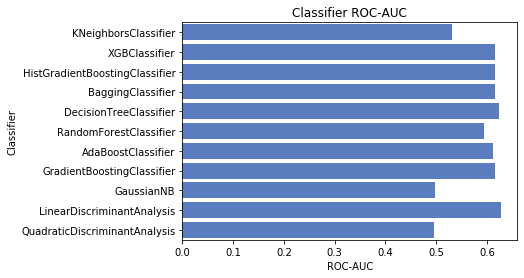

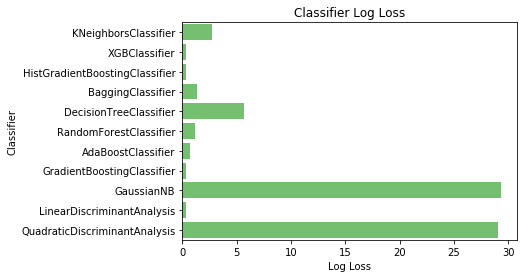

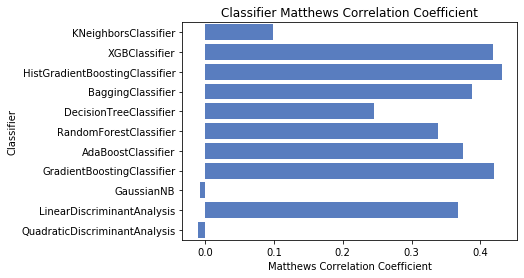

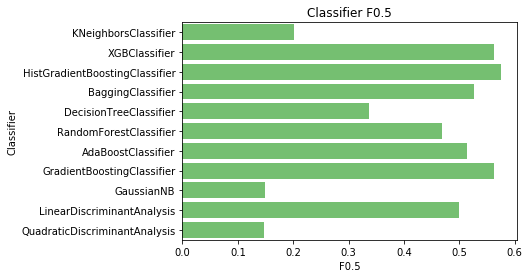

In [73]:
sns.set_color_codes("muted")
sns.barplot(x='ROC-AUC', y='Classifier', data=log, color="b")

plt.xlabel('ROC-AUC')
plt.title('Classifier ROC-AUC')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='mcc', y='Classifier', data=log, color="b")

plt.xlabel('Matthews Correlation Coefficient')
plt.title('Classifier Matthews Correlation Coefficient')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='F0.5', y='Classifier', data=log, color="g")

plt.xlabel('F0.5')
plt.title('Classifier F0.5')
plt.show()

### Based on these baseline, unoptimized, results it looks like Gradient Boosting, Random Forest, and ADABoosting all perform very well. 